<a href="https://colab.research.google.com/github/prantoran/ai-prac/blob/master/Stock_Market_Analytics_Zoomcamp_2025/pinku_stock_markets_analytics_zoomcamp_2025_hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2 Homework (2025 Cohort)

In this homework, we're going to combine data from various sources to process it in Pandas and generate additional fields.

If not stated otherwise, please use the [LINK](https://github.com/DataTalksClub/stock-markets-analytics-zoomcamp/blob/main/02-dataframe-analysis/%5B2025%5D_Module_02_Colab_Working_with_the_data.ipynb) covered at the livestream to re-use the code snippets.


In [251]:
!pip install yfinance

## Question 1: [IPO] Withdrawn IPOs by Company Type

**What is the total withdrawn IPO value (in $ millions) for the company class with the highest total withdrawal value?**

From the withdrawn IPO list ([stockanalysis.com/ipos/withdrawn](https://stockanalysis.com/ipos/withdrawn/)), collect and process the data to find out which company type saw the most withdrawn IPO value.

### Steps:


#### 1. Use `pandas.read_html()` with the URL above to load the IPO withdrawal table into a DataFrame.
   *It is a similar process to Code Snippet 1 discussed at the livestream.*    You should get **99 entries**.

In [252]:
import pandas as pd
import requests
from io import StringIO

In [253]:
def withdrawn_ipos():
  """
  Fetch IPO data for the given year from stockanalysis.com.
  """
  url = f"https://stockanalysis.com/ipos/withdrawn/"
  headers = {
      'User-Agent': (
          'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
          'AppleWebKit/537.36 (KHTML, like Gecko) '
          'Chrome/58.0.3029.110 Safari/537.3'
      )
  }

  try:
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()

    # Wrap HTML text in StringIO to avoid deprecation warning
    # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
    html_io = StringIO(response.text)
    tables = pd.read_html(html_io)

    if not tables:
      raise ValueError(f"No tables found for withdrawn IPOs.")

    return tables[0]

  except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")
  except ValueError as ve:
    print(f"Data error: {ve}")
  except Exception as ex:
    print(f"Unexpected error: {ex}")

  return pd.DataFrame()

In [254]:
w = withdrawn_ipos()

In [255]:
w.head()

,Symbol,Company Name,Price Range,Shares Offered
0,ODTX,"Odyssey Therapeutics, Inc.",-,-
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000
2,AURN,"Aurion Biotech, Inc.",-,-
3,ROTR,"PHI Group, Inc.",-,-
4,ONE,One Power Company,-,-


In [256]:
w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Symbol          100 non-null    object
 1   Company Name    100 non-null    object
 2   Price Range     100 non-null    object
 3   Shares Offered  100 non-null    object
dtypes: object(4)
memory usage: 3.3+ KB


#### 2. Create a new column called `Company Class`, categorizing company names based on patterns like:
   - “Acquisition Corp” or “Acquisition Corporation” → `Acq.Corp`
   - “Inc” or “Incorporated” → `Inc`
   - “Group” → `Group`
   - “Ltd” or “Limited” → `Limited`
   - “Holdings” → `Holdings`
   - Others → `Other`

  *  Order: Please follow the listed order of classes and assign the first matched value (e.g., for 'shenni holdings limited', you assign the 'Limited' class).

  * Hint: make your function more robust by converting names to lowercase and splitting into words before matching patterns.

In [257]:
company_classes = ['Acq.Corp', 'Inc', 'Group', 'Limited', 'Holdings', 'Other']

company_mappings = {
    'acquisition corp': 0,
    'acquisition corporation': 0,
    'inc': 1,
    'incorporated': 1,
    'group': 2,
    'ltd': 3,
    'limited': 3,
    'holdings': 4,
    'others': 5
}

def find_company_class(company_name: str) -> str:
  s = company_name.lower()
  for key, value in company_mappings.items():
    if key in s:
      return company_classes[value]
  return 'Other'

In [258]:
company_class = 'Company Class'
w[company_class] = w['Company Name'].apply(lambda x: find_company_class(x))
w.head()

,Symbol,Company Name,Price Range,Shares Offered,Company Class
0,ODTX,"Odyssey Therapeutics, Inc.",-,-,Inc
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000,Inc
2,AURN,"Aurion Biotech, Inc.",-,-,Inc
3,ROTR,"PHI Group, Inc.",-,-,Inc
4,ONE,One Power Company,-,-,Other


#### 3. Define a new field `Avg. price` by parsing the `Price Range` field (create a function and apply it to the `Price Range` column). Examples:
   - '$8.00-$10.00' → `9.0`  
   - '$5.00' → `5.0`  
   - '-' → `None`

In [259]:
avg_price_key = 'Avg. price'

In [260]:
def calc_avg_price(price_range: str) -> float:
  if price_range == '-':
    return None
  w = price_range.split('-')
  if len(w) == 1:
    return float(w[0].replace('$', ''))
  return (float(w[0].replace('$', '')) + float(w[1].replace('$', ''))) / 2

In [261]:
w[avg_price_key] = w['Price Range'].apply(lambda x: calc_avg_price(x))
w.head()

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. price
0,ODTX,"Odyssey Therapeutics, Inc.",-,-,Inc,NaN
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000,Inc,3.5
2,AURN,"Aurion Biotech, Inc.",-,-,Inc,NaN
3,ROTR,"PHI Group, Inc.",-,-,Inc,NaN
4,ONE,One Power Company,-,-,Other,NaN


#### 4. Convert `Shares Offered` to numeric, clean missing or invalid values.


In [262]:
w['Shares Offered'] = pd.to_numeric(w['Shares Offered'], errors='coerce')
w.head()

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. price
0,ODTX,"Odyssey Therapeutics, Inc.",-,NaN,Inc,NaN
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000.0,Inc,3.5
2,AURN,"Aurion Biotech, Inc.",-,NaN,Inc,NaN
3,ROTR,"PHI Group, Inc.",-,NaN,Inc,NaN
4,ONE,One Power Company,-,NaN,Other,NaN


In [263]:
w = w[w['Shares Offered'].notna()]
w.head()

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. price
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000.0,Inc,3.5
5,HPOT,The Great Restaurant Development Holdings Limited,$4.00 - $6.00,1400000.0,Limited,5.0
6,CABR,"Caring Brands, Inc.",$4.00,750000.0,Inc,4.0
7,SQVI,"Sequoia Vaccines, Inc.",$8.00 - $10.00,2775000.0,Inc,9.0
8,SNI,Shenni Holdings Limited,$4.00 - $6.00,3000000.0,Limited,5.0


In [264]:
w.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72 entries, 1 to 99
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol          72 non-null     object 
 1   Company Name    72 non-null     object 
 2   Price Range     72 non-null     object 
 3   Shares Offered  72 non-null     float64
 4   Company Class   72 non-null     object 
 5   Avg. price      71 non-null     float64
dtypes: float64(2), object(4)
memory usage: 3.9+ KB


#### 5. Create a new column:  
`Withdrawn Value = Shares Offered * Avg Price` (**71 non-null values**)

In [265]:
withdrawn_value_key = 'Withdrawn Value'
w[withdrawn_value_key] = w['Shares Offered'] * w[avg_price_key]
w.head()

,Symbol,Company Name,Price Range,Shares Offered,Company Class,Avg. price,Withdrawn Value
1,UNFL,"Unifoil Holdings, Inc.",$3.00 - $4.00,2000000.0,Inc,3.5,7000000.0
5,HPOT,The Great Restaurant Development Holdings Limited,$4.00 - $6.00,1400000.0,Limited,5.0,7000000.0
6,CABR,"Caring Brands, Inc.",$4.00,750000.0,Inc,4.0,3000000.0
7,SQVI,"Sequoia Vaccines, Inc.",$8.00 - $10.00,2775000.0,Inc,9.0,24975000.0
8,SNI,Shenni Holdings Limited,$4.00 - $6.00,3000000.0,Limited,5.0,15000000.0


#### 6. Group by `Company Class` and calculate total withdrawn value.


In [266]:
w.groupby(company_class)[withdrawn_value_key].sum()

,Withdrawn Value
Company Class,
Acq.Corp,4.021000e+09
Group,3.378750e+07
Holdings,7.500000e+07
Inc,2.257164e+09
Limited,5.497346e+08
Other,7.679200e+08


## Question 2:   [IPO] Median Sharpe Ratio for 2024 IPOs (First 5 Months)


**What is the median Sharpe ratio (as of 6 June 2025) for companies that went public in the first 5 months of 2024?**

The goal is to replicate the large-scale `yfinance` OHLCV data download and perform basic financial calculations on IPO stocks.


### Steps:


#### 1. Using the same approach as in Question 1, download the IPOs in 2024 from:  
   [https://stockanalysis.com/ipos/2024/](https://stockanalysis.com/ipos/2024/)  
   Filter to keep only those IPOs **before 1 June 2024** (first 5 months of 2024).  
   ➤ You should have **75 tickers**.

In [267]:
import pandas as pd
import requests
from io import StringIO

In [268]:
def ipos_2024():
  """
  Fetch IPO data for the given year from stockanalysis.com.
  """
  url = f"https://stockanalysis.com/ipos/2024/"
  headers = {
      'User-Agent': (
          'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
          'AppleWebKit/537.36 (KHTML, like Gecko) '
          'Chrome/58.0.3029.110 Safari/537.3'
      )
  }

  try:
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()

    # Wrap HTML text in StringIO to avoid deprecation warning
    # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
    html_io = StringIO(response.text)
    tables = pd.read_html(html_io)

    if not tables:
      raise ValueError(f"No tables found for withdrawn IPOs.")

    df = tables[0]
    df['Month'] = pd.to_datetime(df['IPO Date']).dt.month
    df = df[df['Month'] < 6]
    return df

  except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")
  except ValueError as ve:
    print(f"Data error: {ve}")
  except Exception as ex:
    print(f"Unexpected error: {ex}")

  return pd.DataFrame()

In [269]:
ipos_2024_df = ipos_2024()
ipos_2024_df.head()

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Month
148,"May 31, 2024",NAKA,"Kindly MD, Inc.",-,$16.30,-,5
149,"May 23, 2024",BOW,Bowhead Specialty Holdings Inc.,$17.00,$37.25,119.12%,5
150,"May 17, 2024",HDL,Super Hi International Holding Ltd.,$19.56,$18.70,-4.40%,5
151,"May 17, 2024",RFAI,RF Acquisition Corp II,$10.00,$10.59,5.90%,5
152,"May 15, 2024",JDZG,JIADE Limited,$4.00,$0.26,-93.50%,5


In [270]:
ipos_2024_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 148 to 224
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      77 non-null     object
 1   Symbol        77 non-null     object
 2   Company Name  77 non-null     object
 3   IPO Price     77 non-null     object
 4   Current       77 non-null     object
 5   Return        77 non-null     object
 6   Month         77 non-null     int32 
dtypes: int32(1), object(6)
memory usage: 4.5+ KB


#### 2.  Use **Code Snippet 7** to download daily stock data for those tickers (via `yfinance`).  
   Make sure you understand how `growth_1d` ... `growth_365d`, and volatility columns are defined.  
   Define a new column `growth_252d` representing growth after **252 trading days** (~1 year), in addition to any other growth periods you already track.


In [271]:
ALL_TICKERS = ipos_2024_df['Symbol'].tolist()

In [272]:


import time
import yfinance as yf
import numpy as np
import pandas as pd

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,252,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)



0 NAKA
1 BOW
2 HDL
3 RFAI
4 JDZG
5 RAY
6 BTOC
7 ZK
8 GPAT
9 PAL
10 SVCO
11 NNE
12 CCIX
13 VIK
14 ZONE
15 LOAR
16 MRX
17 RBRK
18 NCI
19 MFI
20 YYGH
21 TRSG
22 CDTG
23 CTRI
24 IBTA
25 MTEN
26 SUPX
27 TWG
28 ULS
29 PACS
30 MNDR
31 CTNM
32 MAMO
33 ZBAO
34 BOLD
35 MMA
36 UBXG
37 IBAC
38 AUNA
39 BKHA
40 LOBO
41 RDDT
42 ALAB
43 INTJ
44 RYDE
45 LGCL
46 SMXT
47 VHAI
48 DYCQ
49 CHRO
50 UMAC
51 HLXB
52 MGX
53 TBBB
54 TELO
55 KYTX
56 PMNT
57 AHR
58 LEGT
59 ANRO
60 GUTS
61 AS
62 FBLG
63 AVBP
64 BTSG
65 HAO
66 CGON
67 YIBO
68 JL
69 SUGP
70 JVSA
71 KSPI
72 CCTG
73 PSBD
74 SYNX
75 SDHC
76 ROMA


#### 3. Calculate the Sharpe ratio assuming a risk-free rate of **4.5%**:

   ```python
   stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']
   ```

In [273]:
stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']

#### 4. Filter the DataFrame to keep data only for the trading day:  
   **‘2025-06-06’**

   Compute descriptive statistics (e.g., `.describe()`) for these columns:  
   - `growth_252d`  
   - `Sharpe`

   You should observe:  
   - `growth_252d` is defined for **71 out of 75 stocks** (some IPOs are too recent or data starts later).  
   - Median `growth_252d` is approximately **0.75** (indicating a 25% decline), while mean is about **1.15**, showing a bias towards high-growth companies pushing the average up.

In [274]:
stocks_df.Date = pd.to_datetime(stocks_df.Date, format='mixed')

In [275]:
sharpe_df = stocks_df[stocks_df['Date'] == '2025-06-06']

In [276]:
sharpe_df['growth_252d'].median()

0.7631877801587481

In [277]:
sharpe_df['growth_252d'].mean()

np.float64(1.2279479464506708)

#### 5. **Answer:**  
   - What is the **median Sharpe ratio** for these 71 stocks?  
   - Note: Positive `Sharpe` means growth exceeding the risk-free rate of 4.5%.  
   - [Additional] Do you observe the **same top 10 companies** when sorting by `growth_252d` versus sorting by `Sharpe`?

In [278]:
sharpe_df['Sharpe'].median()

0.08376823003294499

In [279]:
sharpe_df['Sharpe'].mean()

np.float64(0.28457624123033315)

In [280]:
sharpe_df.sort_values(by='growth_252d', ascending=False).head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_252d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future,Sharpe
21112,5.310000,5.355000,5.289000,5.320000,7700,0.0,0.0,JL,2025,6,...,8.097413,NaN,NaN,5.303000,4.734600,1,0.012406,14.221305,0,0.566222
23946,3.650000,3.950000,3.630000,3.700000,84400,0.0,0.0,ROMA,2025,6,...,6.156406,NaN,NaN,3.207100,2.625550,1,0.086486,12.553202,0,0.486840
254,16.260000,17.200001,15.550000,15.880000,431200,0.0,0.0,NAKA,2025,6,...,5.438356,NaN,NaN,20.561000,17.248000,1,0.103904,136.860031,0,0.039408
14900,6.810000,8.650000,6.610000,7.420000,10186200,0.0,0.0,UMAC,2025,6,...,4.966533,NaN,NaN,5.861000,5.567000,1,0.274933,11.681615,0,0.421306
3233,29.150000,31.559000,28.350000,31.190001,3244100,0.0,0.0,NNE,2025,6,...,4.655224,NaN,NaN,31.332000,28.784500,1,0.102886,57.122852,0,0.080707
4929,102.800003,103.000000,95.000000,97.910004,6569700,0.0,0.0,RBRK,2025,6,...,3.184065,NaN,NaN,96.484999,90.673499,1,0.081708,164.768721,0,0.019051
17297,35.070000,35.580002,34.755001,35.480000,1715900,0.0,0.0,AHR,2025,6,...,2.483097,NaN,NaN,34.840000,34.803500,1,0.023253,21.657313,0,0.112576
18648,37.540001,37.799999,37.009998,37.520000,4036300,0.0,0.0,AS,2025,6,...,2.478203,NaN,NaN,37.290000,34.883000,1,0.021055,86.819697,0,0.028026
7573,10.470000,10.470000,10.120000,10.135000,51200,0.0,0.0,SUPX,2025,6,...,2.346065,NaN,NaN,10.706200,10.842350,0,0.034534,8.637976,0,0.266389
4639,43.009998,43.020000,42.126999,42.270000,460000,0.0,0.0,MRX,2025,6,...,2.300384,NaN,NaN,43.383000,44.608613,0,0.021126,29.466621,0,0.076540


In [281]:
sharpe_df.sort_values(by='Sharpe', ascending=False).head(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_252d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future,Sharpe
11491,10.600,10.600,10.600,10.600,0,0.0,0.0,BKHA,2025,6,...,1.045881,NaN,NaN,10.5980,10.59750,1,0.000000,0.352961,0,2.835668
21788,10.850,10.850,10.850,10.850,228100,0.0,0.0,JVSA,2025,6,...,1.071076,NaN,NaN,10.8180,10.80500,1,0.000000,0.502601,0,2.041531
17606,10.620,10.620,10.620,10.620,0,0.0,0.0,LEGT,2025,6,...,1.049407,NaN,NaN,10.6251,10.63190,0,0.000000,0.517665,0,1.940267
10900,10.420,10.420,10.420,10.420,100,0.0,0.0,IBAC,2025,6,...,1.044611,NaN,NaN,10.4425,10.41875,1,0.000000,0.610592,0,1.637119
15242,10.800,10.890,10.750,10.890,383400,0.0,0.0,HLXB,2025,6,...,1.061404,NaN,NaN,10.8210,10.83250,0,0.012856,0.904682,0,1.123493
8769,1.310,1.350,1.300,1.340,51800,0.0,0.0,MNDR,2025,6,...,1.030769,NaN,NaN,1.3720,1.36300,1,0.037313,1.011840,0,0.974234
14224,10.780,10.820,10.780,10.800,2500,0.0,0.0,DYCQ,2025,6,...,1.059863,NaN,NaN,10.7260,10.73900,0,0.003704,1.046983,0,0.969321
12748,0.633,0.670,0.605,0.668,31400,0.0,0.0,INTJ,2025,6,...,0.661386,NaN,NaN,0.6126,0.59675,1,0.097305,0.827906,0,0.744512
21112,5.310,5.355,5.289,5.320,7700,0.0,0.0,JL,2025,6,...,8.097413,NaN,NaN,5.3030,4.73460,1,0.012406,14.221305,0,0.566222
6101,1.780,1.820,1.729,1.790,6700,0.0,0.0,TRSG,2025,6,...,0.646209,NaN,NaN,1.8504,1.85700,0,0.050838,1.160458,0,0.518080


## Question 3: [IPO] ‘Fixed Months Holding Strategy’

What is the optimal number of months (1 to 12) to hold a newly IPO'd stock in order to maximize average growth?
(Assume you buy at the close of the first trading day and sell after a fixed number of trading days.)

Goal:
Investigate whether holding an IPO stock for a fixed number of months after its first trading day produces better returns, using future growth columns.

Steps:

### 1. Start from the existing DataFrame from Question 2 (75 tickers from IPOs in the first 5 months of 2024).

Add 12 new columns:

future_growth_1m, future_growth_2m, ..., future_growth_12m
(Assume 1 month = 21 trading days, so growth is calculated over 21, 42, ..., 252 trading days)

This logic is similar to historyPrices['growth_future_30d'] from Code Snippet 7, but extended to longer timeframes.

In [282]:
stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,252,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  for i in range(1,13):
    historyPrices['future_growth_'+str(i)+'m'] = historyPrices['Close'].shift(-i*21) / historyPrices['Close']
  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

stocks_df['Sharpe'] = (stocks_df['growth_252d'] - 0.045) / stocks_df['volatility']


0 NAKA
1 BOW
2 HDL
3 RFAI
4 JDZG
5 RAY
6 BTOC
7 ZK
8 GPAT
9 PAL
10 SVCO
11 NNE
12 CCIX
13 VIK
14 ZONE
15 LOAR
16 MRX
17 RBRK
18 NCI
19 MFI
20 YYGH
21 TRSG
22 CDTG
23 CTRI
24 IBTA
25 MTEN
26 SUPX
27 TWG
28 ULS
29 PACS
30 MNDR
31 CTNM
32 MAMO
33 ZBAO
34 BOLD
35 MMA
36 UBXG
37 IBAC
38 AUNA
39 BKHA
40 LOBO
41 RDDT
42 ALAB
43 INTJ
44 RYDE
45 LGCL
46 SMXT
47 VHAI
48 DYCQ
49 CHRO
50 UMAC
51 HLXB
52 MGX
53 TBBB
54 TELO
55 KYTX
56 PMNT
57 AHR
58 LEGT
59 ANRO
60 GUTS
61 AS
62 FBLG
63 AVBP
64 BTSG
65 HAO
66 CGON
67 YIBO
68 JL
69 SUGP
70 JVSA
71 KSPI
72 CCTG
73 PSBD
74 SYNX
75 SDHC
76 ROMA


In [283]:
stocks_df = stocks_df[stocks_df['Month'] < 6]

In [284]:
stocks_df.head(1).T

,0
Open,4.0
High,4.2
Low,2.8
Close,3.02
Volume,440600
Dividends,0.0
Stock Splits,0.0
Ticker,NAKA
Year,2024
Month,5


### 2. **Determine the first trading day** (`min_date`) for each ticker.  


   This is the earliest date in the data for each stock.

In [285]:
min_date_df = stocks_df[['Ticker', 'Date']].groupby(['Ticker']).min()
min_date_df

,Date
Ticker,
AHR,2024-02-07
ALAB,2024-03-20
ANRO,2024-02-02
AS,2024-02-01
AUNA,2024-03-22
...,...
YIBO,2024-01-25
YYGH,2024-04-22
ZBAO,2024-04-02


### 3. **Join the data**:  
Perform an **inner join** between the `min_date` DataFrame and the future growth data on both `ticker` and `date`.  
➤ You should end up with **75 records** (one per IPO) with all 12 `future_growth_...` fields populated.

In [286]:
future_growth_columns = ['future_growth_'+str(i)+'m' for i in range(1, 13)]
growth_data_first_day = stocks_df.merge(min_date_df, on=['Ticker', 'Date'], how='inner')
growth_data_first_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 39 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Open                           77 non-null     float64
 1   High                           77 non-null     float64
 2   Low                            77 non-null     float64
 3   Close                          77 non-null     float64
 4   Volume                         77 non-null     int64  
 5   Dividends                      77 non-null     float64
 6   Stock Splits                   77 non-null     float64
 7   Ticker                         77 non-null     object 
 8   Year                           77 non-null     int32  
 9   Month                          77 non-null     int32  
 10  Weekday                        77 non-null     int32  
 11  Date                           77 non-null     object 
 12  growth_1d                      4 non-null      float

In [287]:
growth_data_first_day

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,future_growth_4m,future_growth_5m,future_growth_6m,future_growth_7m,future_growth_8m,future_growth_9m,future_growth_10m,future_growth_11m,future_growth_12m,Sharpe
0,4.000000,4.200000,2.800000,3.020000,440600,0.0,0.0,NAKA,2024,5,...,0.350993,0.341060,0.387417,0.410596,0.397351,0.586093,0.516556,0.897351,5.672185,NaN
1,23.000000,24.270000,22.139999,23.799999,3335800,0.0,0.0,BOW,2024,5,...,1.167647,1.239076,1.461765,1.443698,1.357983,1.389076,1.722689,1.698319,1.533613,NaN
2,27.000000,30.000000,19.799999,22.290001,670000,0.0,0.0,HDL,2024,5,...,0.643786,0.720502,0.719605,1.255271,1.106326,1.030507,1.192014,0.907133,1.002602,NaN
3,10.220000,10.220000,10.220000,10.220000,98400,0.0,0.0,RFAI,2025,1,...,1.022505,1.028376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.800000,5.400000,3.595000,4.070000,2366200,0.0,0.0,JDZG,2024,5,...,0.160442,0.272727,0.199017,0.139066,0.182555,0.170025,0.146437,0.121867,0.142506,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,5.750000,9.833000,5.030000,7.700000,5181000,0.0,0.0,CCTG,2024,1,...,0.316883,0.279221,0.290909,0.206494,0.225974,0.232468,0.196104,0.198701,0.228571,NaN
73,14.039482,14.220914,13.832130,13.987644,1044800,0.0,0.0,PSBD,2024,1,...,1.060584,1.061857,1.081292,1.066809,1.074739,1.096368,1.063983,1.060609,1.095498,NaN
74,3.990000,4.000000,3.260000,3.610000,711400,0.0,0.0,SYNX,2024,1,...,0.664820,0.753463,0.761773,0.844875,0.844875,0.822715,0.767313,0.825485,1.177285,NaN
75,23.820000,24.670000,23.500000,24.150000,426100,0.0,0.0,SDHC,2024,1,...,1.209938,1.036025,1.130849,1.426915,1.484886,1.548654,1.285714,1.340373,1.024017,NaN


### 4. **Compute descriptive statistics** for the resulting DataFrame:  
Use `.describe()` or similar to analyze each of the 12 columns:  
- `future_growth_1m`  
- `future_growth_2m`  
- ...  
- `future_growth_12m`

In [288]:
growth_data_first_day[future_growth_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
future_growth_1m,77.0,0.933317,0.338013,0.098947,0.782732,0.977000,1.047796,2.646505
future_growth_2m,77.0,0.934170,0.571808,0.073800,0.680193,1.000000,1.139076,4.874759
future_growth_3m,77.0,0.831506,0.414872,0.060947,0.508139,0.927500,1.075676,2.040000
future_growth_4m,77.0,0.820135,0.407245,0.045368,0.515385,0.909091,1.125316,1.605000
future_growth_5m,77.0,0.800903,0.490725,0.054109,0.445378,0.821092,1.033981,3.213873
future_growth_6m,73.0,0.867432,0.661048,0.061432,0.387417,0.782463,1.130849,3.670520
future_growth_7m,73.0,0.849018,0.719645,0.044086,0.324100,0.840000,1.158009,5.122350
future_growth_8m,73.0,0.832196,0.768259,0.050746,0.225974,0.770270,1.090127,5.171484
future_growth_9m,73.0,0.883388,0.944928,0.033144,0.232468,0.735931,1.037624,6.764933
future_growth_10m,73.0,0.907403,0.918477,0.037769,0.239394,0.665816,1.203716,5.352601


### 5. **Determine the best holding period**:  
- Find the number of months **(1 to 12)** where the **average (mean)** future growth is **maximal**.  
- This optimal month shows an uplift of **>1%** compared to all others.  
- Still, the average return remains **less than 1** (i.e., expected return is less than doubling your investment).



## Question 4: [Strategy] Simple RSI-Based Trading Strategy


**What is the total profit (in $thousands) you would have earned by investing $1000 every time a stock was oversold (RSI < 25)?**

### Goal:
Apply a simple rule-based trading strategy using the **Relative Strength Index (RSI)** technical indicator to identify oversold signals and calculate profits.

### Steps:

### 1. **Run the full notebook from Lecture 2 (33 stocks)**  
   - Ensure you can generate the merged DataFrame containing:  
     - OHLCV data  
     - Technical indicators  
     - Macro indicators  
   - Focus on getting **RSI** computed using **Code Snippets 8 and 9**.  
   - This process is essential and will help during the capstone project.

In [289]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230448 entries, 0 to 5707
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.4+ MB


In [291]:
m16['rsi']

,rsi
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
5703,53.791785
5704,56.464125
5705,61.471431
5706,49.688854


### 2. ⚠️ **IMPORTANT** Please use this file to solve the Home Assignment (**all next steps**)

Download precomputed data using this snippet:

   ```python
   import gdown
   import pandas as pd

   file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
   gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
   df = pd.read_parquet("data.parquet", engine="pyarrow")
   ```

In [292]:
import gdown
import pandas as pd

file_id = "1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "data.parquet", quiet=False)
df = pd.read_parquet("data.parquet", engine="pyarrow")

Downloading...
From (original): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-
From (redirected): https://drive.google.com/uc?id=1grCTCzMZKY5sJRtdbLVCXg8JXA8VPyg-&confirm=t&uuid=c0fd2e3f-d568-4ed5-9ef5-21a12e03f903
To: /content/data.parquet
100%|██████████| 130M/130M [00:04<00:00, 29.0MB/s]


### 3. **RSI Strategy Setup:**  
- RSI is already available in the dataset as a field.  
- The threshold for **oversold** is defined as `RSI < 25`.

In [295]:
df['rsi']

,rsi
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
5686,68.312972
5687,67.123448
5688,67.563912
5689,68.218963


### 4. **Filter the dataset by RSI and date:**  
```python

rsi_threshold = 25
selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
]
```

In [296]:
rsi_threshold = 25
selected_df = df[
    (df['rsi'] < rsi_threshold) &
    (df['Date'] >= '2000-01-01') &
    (df['Date'] <= '2025-06-01')
]

### 5. **Calculate Net Profit Over 25 Years:**  

- Total number of trades: **1568**  
- For each trade, you invest **$1000**  
- Use the 30-day forward return (`growth_future_30d`) to compute net earnings:  
  ```python
  net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()
  ```

- **Final Answer:**  
  What is the **net income in $K** (i.e., in thousands of dollars) that could be earned using this RSI-based oversold strategy from 2000–2025?

In [297]:
selected_df.shape

(1568, 203)

In [301]:
selected_df.tail()['growth_future_30d']

,growth_future_30d
4405,1.007871
4406,0.981580
4407,1.118479
4408,1.142111
4409,1.011231


In [298]:
net_income = 1000 * (selected_df['growth_future_30d'] - 1).sum()

In [299]:
net_income

np.float64(24295.523125248386)

## Q5. [Exploratory, Optional] Predicting a Positive-Return IPO

Most of the strategies for investing in IPOs deliver **negative average and median returns** (and even 75% quantiles).

**Question:**  
How would you change the strategy if you want to **increase the profitability**?

> This is an open-ended brainstorming question — propose ideas for identifying IPOs with positive future returns or building a more effective trading strategy.

# Practice

### Imports

In [39]:


# IMPORTS
import numpy as np
import pandas as pd
import requests


#Fin Data Sources
import yfinance as yf
import pandas_datareader as pdr

#Data viz
import plotly.graph_objs as go
import plotly.express as px

import time
from datetime import date

# for graphs
import matplotlib.pyplot as plt



## 1) [Code Snippet 1] IPOs data from Web


    learn dataframes "stacking" (UNION ALL)
    learn about type casting
    generate new columns (simple and with function)


In [40]:
import pandas as pd
import requests
from io import StringIO

def get_ipos_by_year(year: int) -> pd.DataFrame:
    """
    Fetch IPO data for the given year from stockanalysis.com.
    """
    url = f"https://stockanalysis.com/ipos/{year}/"
    headers = {
        'User-Agent': (
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) '
            'AppleWebKit/537.36 (KHTML, like Gecko) '
            'Chrome/58.0.3029.110 Safari/537.3'
        )
    }

    try:
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()

        # Wrap HTML text in StringIO to avoid deprecation warning
        # "Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object."
        html_io = StringIO(response.text)
        tables = pd.read_html(html_io)

        if not tables:
            raise ValueError(f"No tables found for year {year}.")

        return tables[0]

    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
    except ValueError as ve:
        print(f"Data error: {ve}")
    except Exception as ex:
        print(f"Unexpected error: {ex}")

    return pd.DataFrame()

In [41]:
ipos_2018 = get_ipos_by_year(2018)
ipos_2018.info()


Request failed: 404 Client Error: Not Found for url: https://stockanalysis.com/ipos/2018/
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame


In [42]:
ipos_2019 = get_ipos_by_year(2019)
ipos_2019.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      232 non-null    object
 1   Symbol        232 non-null    object
 2   Company Name  232 non-null    object
 3   IPO Price     232 non-null    object
 4   Current       232 non-null    object
 5   Return        232 non-null    object
dtypes: object(6)
memory usage: 11.0+ KB


In [43]:
ipos_2020 = get_ipos_by_year(2020)
ipos_2020.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      480 non-null    object
 1   Symbol        480 non-null    object
 2   Company Name  480 non-null    object
 3   IPO Price     480 non-null    object
 4   Current       480 non-null    object
 5   Return        480 non-null    object
dtypes: object(6)
memory usage: 22.6+ KB


In [44]:
ipos_2021 = get_ipos_by_year(2021)
ipos_2021.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      1035 non-null   object
 1   Symbol        1035 non-null   object
 2   Company Name  1035 non-null   object
 3   IPO Price     1035 non-null   object
 4   Current       1035 non-null   object
 5   Return        1035 non-null   object
dtypes: object(6)
memory usage: 48.6+ KB


In [45]:
ipos_2022 = get_ipos_by_year(2022)
ipos_2022.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      181 non-null    object
 1   Symbol        180 non-null    object
 2   Company Name  181 non-null    object
 3   IPO Price     181 non-null    object
 4   Current       181 non-null    object
 5   Return        181 non-null    object
dtypes: object(6)
memory usage: 8.6+ KB


In [46]:


ipos_2023 = get_ipos_by_year(2023)
ipos_2023.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154 entries, 0 to 153
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      154 non-null    object
 1   Symbol        154 non-null    object
 2   Company Name  154 non-null    object
 3   IPO Price     154 non-null    object
 4   Current       154 non-null    object
 5   Return        154 non-null    object
dtypes: object(6)
memory usage: 7.3+ KB


In [47]:
ipos_2024 = get_ipos_by_year(2024)
ipos_2024.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      225 non-null    object
 1   Symbol        225 non-null    object
 2   Company Name  225 non-null    object
 3   IPO Price     225 non-null    object
 4   Current       225 non-null    object
 5   Return        225 non-null    object
dtypes: object(6)
memory usage: 10.7+ KB


In [48]:


ipos_2025 = get_ipos_by_year(2025)
ipos_2025.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157 entries, 0 to 156
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      157 non-null    object
 1   Symbol        157 non-null    object
 2   Company Name  157 non-null    object
 3   IPO Price     157 non-null    object
 4   Current       157 non-null    object
 5   Return        157 non-null    object
dtypes: object(6)
memory usage: 7.5+ KB


In [49]:


# "stacking dataframes"
# pd.concat() is used to concatenate the DataFrames vertically.
# The ignore_index=True parameter ensures that the resulting DataFrame has a new index,
# ignoring the original indices of the input DataFrames.
# The stacked_df now contains the concatenated DataFrame.
stacked_ipos_df = pd.concat([ipos_2025, ipos_2024, ipos_2023, ipos_2022, ipos_2021, ipos_2020, ipos_2019, ipos_2018], ignore_index=True)



In [50]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return
0,"Jun 18, 2025",AXIN,Axiom Intelligence Acquisition Corp 1,$10.00,$10.08,0.80%


In [51]:


# Need to convert everything to a proper type (date, str, int, float, etc.)
stacked_ipos_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2464 entries, 0 to 2463
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   IPO Date      2464 non-null   object
 1   Symbol        2463 non-null   object
 2   Company Name  2464 non-null   object
 3   IPO Price     2464 non-null   object
 4   Current       2464 non-null   object
 5   Return        2464 non-null   object
dtypes: object(6)
memory usage: 115.6+ KB


In [52]:
# convert to datetime
stacked_ipos_df['IPO Date'] = pd.to_datetime(stacked_ipos_df['IPO Date'], format='mixed')

In [53]:


# Problem --> not always the columns are filled
missing_prices_df = stacked_ipos_df[stacked_ipos_df['IPO Price'].astype(str).str.find('-') >= 0]
missing_prices_df



,IPO Date,Symbol,Company Name,IPO Price,Current,Return
76,2025-04-02,SORA,Top Win International Limited,-,$6.27,-
218,2024-10-11,STFS,Star Fashion Culture Holdings Limited,-,$1.14,-
277,2024-07-23,ZDAI,Primega Group Holdings Limited,-,$0.85,-
305,2024-05-31,NAKA,"Kindly MD, Inc.",-,$16.30,-
331,2024-04-17,SUPX,SuperX AI Technology Limited,-,$9.94,-
677,2022-02-04,LIEN,"Chicago Atlantic BDC, Inc.",-,$9.95,-
742,2021-12-14,AMZE,"Amaze Holdings, Inc.",-,$10.25,-
785,2021-11-24,MKULQ,"Molekule Group, Inc.",-,-,-
806,2021-11-17,SEVCF,Sono Group N.V.,-,$0.04,-
990,2021-09-24,GIA,"GigCapital5, Inc.",-,$4.00,-


In [54]:


# it has some missing values --> use defensive errors='coerce' (if don't have time to crack into the data errors)
#     : pd.to_numeric() function call, which will convert problematic values to NaN.
#     otherwise you'll get a ValueError: Unable to parse string "-" at position 9
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'].str.replace('$', ''), errors='coerce')
# not sure why, but need to call it again to transform 'object' to 'float64'
stacked_ipos_df['IPO Price'] = pd.to_numeric(stacked_ipos_df['IPO Price'])



In [55]:


# Convert "Current" column
stacked_ipos_df['Current'] = pd.to_numeric(stacked_ipos_df['Current'].str.replace('$', ''), errors='coerce')

# Convert 'Return' to numeric format (percentage)
stacked_ipos_df['Return'] = pd.to_numeric(stacked_ipos_df['Return'].str.replace('%', ''), errors='coerce') / 100



In [56]:


# Correctly applied transformations with 'defensive' techniques, but now not all are non-null
stacked_ipos_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2464 entries, 0 to 2463
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   IPO Date      2464 non-null   datetime64[ns]
 1   Symbol        2463 non-null   object        
 2   Company Name  2464 non-null   object        
 3   IPO Price     2435 non-null   float64       
 4   Current       2394 non-null   float64       
 5   Return        2352 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 115.6+ KB


In [57]:


# simple way of checking NULLs
# (you need to understand how vector operations work .isnull() and calls chaining .isnull().sum())
stacked_ipos_df.isnull().sum()



,0
IPO Date,0
Symbol,1
Company Name,0
IPO Price,29
Current,70
Return,112


In [58]:


# Do you want to leave the record or not?
stacked_ipos_df[stacked_ipos_df.Return.isnull()]



,IPO Date,Symbol,Company Name,IPO Price,Current,Return
76,2025-04-02,SORA,Top Win International Limited,NaN,6.27,NaN
77,2025-04-02,SZZL,Sizzle Acquisition Corp. II,10.0,10.00,NaN
218,2024-10-11,STFS,Star Fashion Culture Holdings Limited,NaN,1.14,NaN
277,2024-07-23,ZDAI,Primega Group Holdings Limited,NaN,0.85,NaN
305,2024-05-31,NAKA,"Kindly MD, Inc.",NaN,16.30,NaN
...,...,...,...,...,...,...
2387,2019-05-09,HHR,Headhunter Group PLC,13.5,NaN,NaN
2421,2019-04-02,XTKG,"X3 Holdings Co., Ltd.",NaN,2.20,NaN
2422,2019-03-29,HPH,Highest Performances Holdings Inc.,NaN,6.65,NaN
2434,2019-03-07,SWAV,"Shockwave Medical, Inc.",17.0,334.75,NaN


In [59]:

# now you can operate with columns as a numeric type
stacked_ipos_df['IPO Price'].mean()

np.float64(12.84369609856263)

In [60]:


# generate a new field -- SIMPLE calculation (no function needed)
stacked_ipos_df['Price Increase'] = stacked_ipos_df['Current'] - stacked_ipos_df['IPO Price']
stacked_ipos_df['Price Increase'].mean()



np.float64(0.5344055649241147)

In [61]:
stacked_ipos_df.head(1)

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase
0,2025-06-18,AXIN,Axiom Intelligence Acquisition Corp 1,10.0,10.08,0.008,0.08


In [62]:
# Descriptive Analytics of a dataset
stacked_ipos_df.describe()

,IPO Date,IPO Price,Current,Return,Price Increase
count,2464,2435.000000,2394.000000,2352.000000,2372.000000
mean,2021-10-31 08:52:24.155844096,12.843696,13.378659,-0.058584,0.534406
min,2019-01-04 00:00:00,2.500000,0.000000,-1.000000,-89.150000
25%,2020-11-19 00:00:00,10.000000,3.650000,-0.631400,-4.807500
50%,2021-06-16 00:00:00,10.000000,10.080000,-0.015500,-0.080000
75%,2022-05-06 00:00:00,15.000000,11.577500,0.097000,0.980000
max,2025-06-18 00:00:00,250.000000,491.810000,9.670700,457.810000
std,NaN,10.742195,26.700872,0.921153,22.913276


In [63]:
# some visualisation: bar chart using Plotly Express
import plotly.express as px

# Truncate to the first day in the month - for Bar names
stacked_ipos_df['Date_monthly'] = stacked_ipos_df['IPO Date'].dt.to_period('M').dt.to_timestamp()

# Count the number of deals for each month and year
monthly_deals = stacked_ipos_df['Date_monthly'].value_counts().reset_index().sort_values(by='Date_monthly')
monthly_deals.columns = ['Date_monthly', 'Number of Deals']

# Plotting the bar chart using Plotly Express
fig = px.bar(monthly_deals,
             x='Date_monthly',
             y='Number of Deals',
             labels={'Month_Year': 'Month and Year', 'Number of Deals': 'Number of Deals'},
             title='Number of IPO Deals per Month and Year',
             text='Number of Deals'
             )
fig.update_traces(textposition='outside', # Position the text outside the bars
                  textfont=dict(color='black',size=14), # Adjust the font size of the text
                  )
fig.update_layout(title_x=0.5) # Center the title

fig.show()

In [64]:
rddt_filter = stacked_ipos_df.Symbol=='RDDT'
stacked_ipos_df[rddt_filter]

,IPO Date,Symbol,Company Name,IPO Price,Current,Return,Price Increase,Date_monthly
346,2024-03-21,RDDT,"Reddit, Inc.",34.0,134.14,2.9453,100.14,2024-03-01


In [65]:


# To be used for home assignment: 'You can notice a bump in the price after the IPO? And after that the price goes down
# You're asked to design a simple strategy to buy and hold for X days (at 'Adj.Close' price, no fees)
# Find an optimal X between 1 and 30, that delivers you a MAX mean return on ALL 2023 IPOs?
# Write down the answer X (a number between 1 and 30)

# What is the distribution of other returns 25-50-75% quantiles? Compare mean and median returns for 2023 (median may be more robust),
  # are you losing money in 25% cases (if 25% quantile returns is < 0)
  # Try the same X for all deals in 2024.  How the mean return in 2024 (out of sample data) is different from 2023 data?

# REDDIT - recent IPO
# https://finance.yahoo.com/quote/RDDT/
ticker_obj = yf.Ticker("RDDT")
reddit = ticker_obj.history(period = "max", interval = "1d")

reddit.tail()



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-16 00:00:00-04:00,121.425003,126.589996,121.425003,126.199997,8405100,0.0,0.0
2025-06-17 00:00:00-04:00,133.649994,146.164001,132.410004,133.839996,23521800,0.0,0.0
2025-06-18 00:00:00-04:00,132.320007,143.889999,132.250000,141.160004,12180700,0.0,0.0
2025-06-20 00:00:00-04:00,141.509995,147.998993,138.098007,139.149994,8787300,0.0,0.0
2025-06-23 00:00:00-04:00,135.770004,141.669998,133.279999,134.139999,6989500,0.0,0.0


<Axes: title={'center': "Reddit's (RDDT) price after the IPO"}, xlabel='Date'>

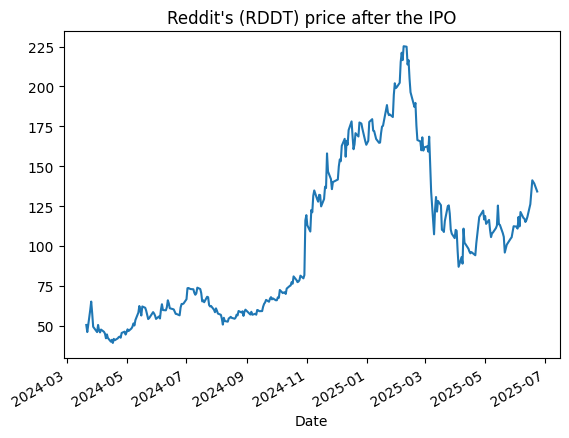

In [66]:
reddit['Close'].plot.line(title='Reddit\'s (RDDT) price after the IPO')

## 2) OHLCV data transformations

### 2.1 [Code Snippet 2] Time series for OHLCV


In [67]:
ticker_obj = yf.Ticker("NVO")
nvo_df = ticker_obj.history(period = "max", interval = "1d")

In [68]:


# big plus of an API's data: good typing from the box!
# notice DatetimeIndex - it is a recognised date
nvo_df.info()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11127 entries, 1981-04-30 00:00:00-04:00 to 2025-06-23 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          11127 non-null  float64
 1   High          11127 non-null  float64
 2   Low           11127 non-null  float64
 3   Close         11127 non-null  float64
 4   Volume        11127 non-null  int64  
 5   Dividends     11127 non-null  float64
 6   Stock Splits  11127 non-null  float64
dtypes: float64(6), int64(1)
memory usage: 695.4 KB


In [69]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-16 00:00:00-04:00,77.839996,78.379997,76.620003,77.019997,8181900,0.0,0.0
2025-06-17 00:00:00-04:00,75.510002,75.779999,74.139999,74.339996,8080000,0.0,0.0
2025-06-18 00:00:00-04:00,74.559998,74.820000,73.699997,74.010002,5462300,0.0,0.0
2025-06-20 00:00:00-04:00,73.839996,74.379997,72.739998,73.769997,8213000,0.0,0.0
2025-06-23 00:00:00-04:00,68.870003,70.050003,68.540001,69.720001,15346600,0.0,0.0


In [70]:


# filter on date (index)
nvo_df_filtered_from_2020 = nvo_df[nvo_df.index>='2020-01-01']
nvo_df_filtered_from_2024 = nvo_df[nvo_df.index>='2024-01-01']



<Axes: title={'center': 'Novo Nordisk A/S (NVO) price daily'}, xlabel='Date'>

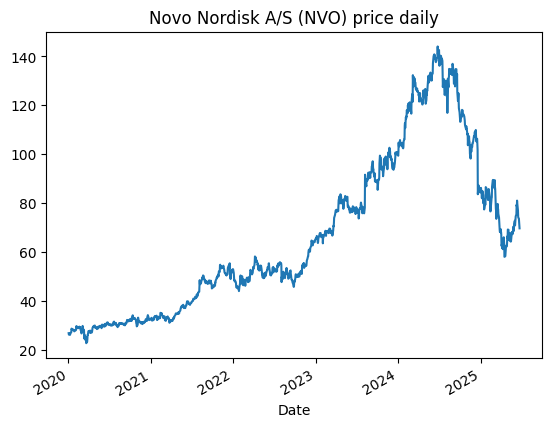

In [71]:
# Chaining: select one column, draw a plot, of a type line
nvo_df_filtered_from_2020['Close'].plot.line(title='Novo Nordisk A/S (NVO) price daily')


In [72]:
# generating new fields (using DateTime features):

nvo_df['Ticker'] = 'NVO'
nvo_df['Year']= nvo_df.index.year
nvo_df['Month'] = nvo_df.index.month
nvo_df['Weekday'] = nvo_df.index.weekday
nvo_df['Date'] = nvo_df.index.date # to be used in joins

In [73]:
nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date
Date,,,,,,,,,,,,
2025-06-16 00:00:00-04:00,77.839996,78.379997,76.620003,77.019997,8181900,0.0,0.0,NVO,2025,6,0,2025-06-16
2025-06-17 00:00:00-04:00,75.510002,75.779999,74.139999,74.339996,8080000,0.0,0.0,NVO,2025,6,1,2025-06-17
2025-06-18 00:00:00-04:00,74.559998,74.820000,73.699997,74.010002,5462300,0.0,0.0,NVO,2025,6,2,2025-06-18
2025-06-20 00:00:00-04:00,73.839996,74.379997,72.739998,73.769997,8213000,0.0,0.0,NVO,2025,6,4,2025-06-20
2025-06-23 00:00:00-04:00,68.870003,70.050003,68.540001,69.720001,15346600,0.0,0.0,NVO,2025,6,0,2025-06-23


In [74]:
# shift ALL values (on x periods forward (+1) and backward (-1))
# equivalent of joining with a dataframe of the same vector, but with shifted date index
nvo_df['close_minus_1'] = nvo_df['Close'].shift(-1)
nvo_df['close_plus_1'] = nvo_df['Close'].shift(1)

nvo_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,Weekday,Date,close_minus_1,close_plus_1
Date,,,,,,,,,,,,,,
2025-06-16 00:00:00-04:00,77.839996,78.379997,76.620003,77.019997,8181900,0.0,0.0,NVO,2025,6,0,2025-06-16,74.339996,79.830002
2025-06-17 00:00:00-04:00,75.510002,75.779999,74.139999,74.339996,8080000,0.0,0.0,NVO,2025,6,1,2025-06-17,74.010002,77.019997
2025-06-18 00:00:00-04:00,74.559998,74.820000,73.699997,74.010002,5462300,0.0,0.0,NVO,2025,6,2,2025-06-18,73.769997,74.339996
2025-06-20 00:00:00-04:00,73.839996,74.379997,72.739998,73.769997,8213000,0.0,0.0,NVO,2025,6,4,2025-06-20,69.720001,74.010002
2025-06-23 00:00:00-04:00,68.870003,70.050003,68.540001,69.720001,15346600,0.0,0.0,NVO,2025,6,0,2025-06-23,NaN,73.769997


In [75]:
# historical growth
nvo_df['growth_1d'] = nvo_df['Close'] / nvo_df['Close'].shift(1)           # nvo_df['close_plus_1']
nvo_df['growth_30d'] = nvo_df['Close'] / nvo_df['Close'].shift(30)

# FUTURE Growth : for regression models
nvo_df['growth_future_1d'] = nvo_df['Close'].shift(-1) / nvo_df['Close']   # nvo_df['close_minus_1']
nvo_df['growth_future_30d'] = nvo_df['Close'].shift(-30) / nvo_df['Close']   # nvo_df['close_minus_1']


# FUTURE Growth: for binary models
nvo_df['is_positive_growth_1d_future'] = np.where(nvo_df['growth_future_1d'] > 1, 1, 0)
nvo_df['is_positive_growth_30d_future'] = np.where(nvo_df['growth_future_30d'] > 1, 1, 0)


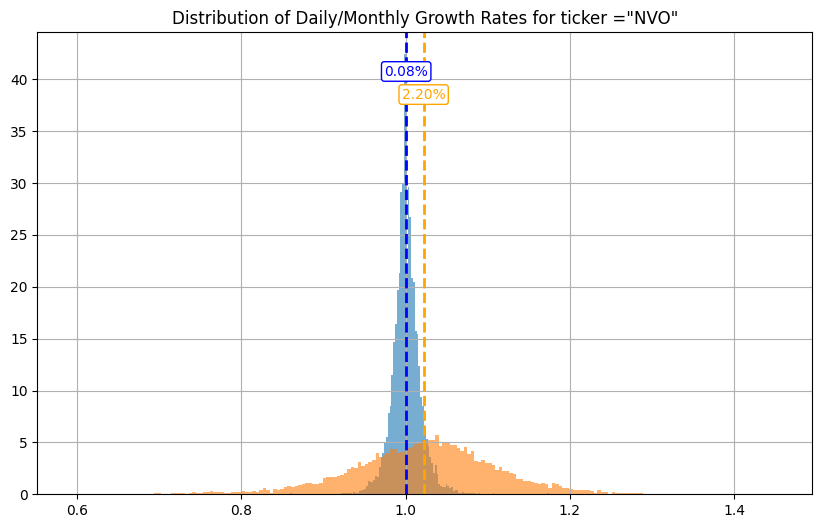

In [76]:

# normally the growth in 1 day is +-10%, while a lot of it is around 0% (around 1.)
plt.figure(figsize=(10, 6))
plt.title('Distribution of Daily/Monthly Growth Rates for ticker ="NVO"')

nvo_df.growth_1d.hist(bins=200, alpha=0.6, density=True)
nvo_df.growth_30d.hist(bins=200, alpha=0.6, density=True)

# Add vertical lines for averages
mean_1d = nvo_df.growth_1d.mean()
mean_30d = nvo_df.growth_30d.mean()

plt.axvline(mean_1d, color='blue', linestyle='--', linewidth=2, label=f'1d avg = {mean_1d:.3f}')
plt.axvline(mean_30d, color='orange', linestyle='--', linewidth=2, label=f'30d avg = {mean_30d:.3f}')


# Add mean text labels (as percent change)
ymax = plt.ylim()[1]
plt.text(mean_1d, ymax * 0.90,
         f'{(mean_1d - 1) * 100:.2f}%',
         color='blue', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round,pad=0.2'))

plt.text(mean_30d, ymax * 0.85,
         f'{(mean_30d - 1) * 100:.2f}%',
         color='orange', ha='center', va='bottom',
         bbox=dict(facecolor='white', edgecolor='orange', boxstyle='round,pad=0.2'))


plt.show()

In [77]:
mean_1d

np.float64(1.0007746160118027)

In [78]:
mean_30d

np.float64(1.0220299766500267)

In [79]:
ymax

np.float64(44.52315723912487)

(np.float64(0.0), np.float64(1.0))

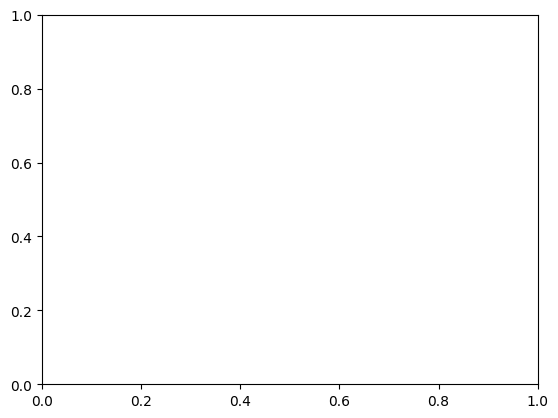

In [80]:
plt.ylim()

np.float64(1.0)

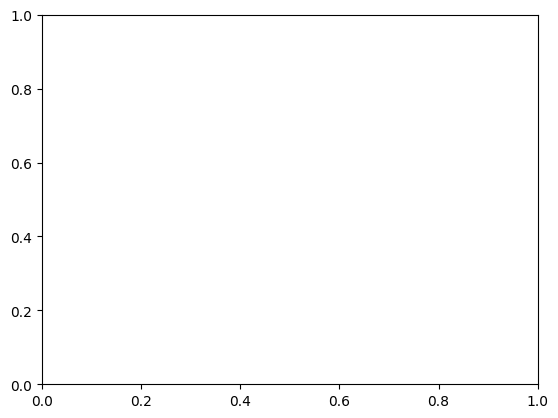

In [81]:
plt.ylim()[1]

<Axes: title={'center': 'Distribution of 2-days Growth Rates for ticker = "NVO"'}>

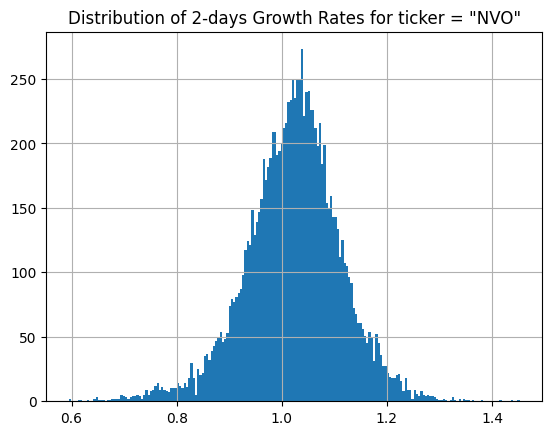

In [82]:
# you can see that the growth is can be much wider in 30 days (+- 30%)
plt.title('Distribution of 2-days Growth Rates for ticker = "NVO"')

nvo_df.growth_30d.hist(bins=200)

In [83]:


# for modeling: we use growth_1d, growth_2d as feature
COLUMNS = [k for k in nvo_df.keys() if k.find('growth')>=0 or k=='Close']
nvo_df[COLUMNS].tail()



,Close,growth_1d,growth_30d,growth_future_1d,growth_future_30d,is_positive_growth_1d_future,is_positive_growth_30d_future
Date,,,,,,,
2025-06-16 00:00:00-04:00,77.019997,0.964800,1.112523,0.965204,NaN,0,0
2025-06-17 00:00:00-04:00,74.339996,0.965204,1.075521,0.995561,NaN,0,0
2025-06-18 00:00:00-04:00,74.010002,0.995561,1.116458,0.996757,NaN,0,0
2025-06-20 00:00:00-04:00,73.769997,0.996757,1.092080,0.945100,NaN,0,0
2025-06-23 00:00:00-04:00,69.720001,0.945100,1.075096,NaN,NaN,0,0


In [84]:


# Calculate the distribution if future growth
nvo_df.is_positive_growth_1d_future.value_counts() / len(nvo_df)



,count
is_positive_growth_1d_future,
0,0.513076
1,0.486924


In [85]:
nvo_df.is_positive_growth_30d_future.value_counts() / len(nvo_df)

,count
is_positive_growth_30d_future,
1,0.620113
0,0.379887


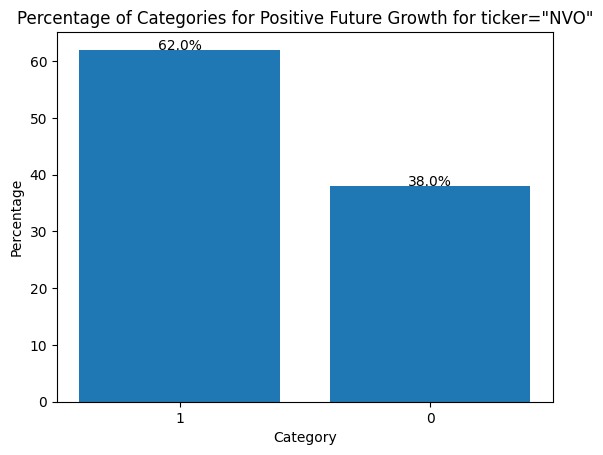

In [86]:
# Calculate value counts
value_counts = nvo_df['is_positive_growth_30d_future'].value_counts()

# Calculate percentage of each category
percentage = (value_counts / len(nvo_df)) * 100

# Plot as a bar chart
plt.bar(percentage.index.astype(str), percentage)
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.title('Percentage of Categories for Positive Future Growth for ticker="NVO"')

# Add percentage values on top of each bar
for i, value in enumerate(percentage):
    plt.text(i, value + 0, f'{value:.1f}%', ha='center')

plt.show()

### 2.2) [Code Snippet 6] Candlestick chart for OHLCV



In [87]:
# Candlestick charts : https://plotly.com/python/candlestick-charts/
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=nvo_df_filtered_from_2020.index,
                open=nvo_df_filtered_from_2020.Open,
                high=nvo_df_filtered_from_2020.High,
                low=nvo_df_filtered_from_2020.Low,
                close=nvo_df_filtered_from_2020.Close)
               ])

fig.update_layout(
    title="NVO's daily candlestick chart from 2020",
    title_x=0.5,  # Set title x-position to center
    xaxis_rangeslider_visible=True
    )

fig.show()

## 3) Macro Indicators

### 3.0) Previous indicators from module 1

In [88]:
end = date.today()
print(f'Year = {end.year}; month= {end.month}; day={end.day}')

start = date(year=end.year-70, month=end.month, day=end.day)
print(f'Period for indexes: {start} to {end} ')

Year = 2025; month= 6; day=24
Period for indexes: 1955-06-24 to 2025-06-24 


In [89]:
# reuse code for ealier covered indicators
ticker_obj = yf.Ticker("^GDAXI")
dax_daily = ticker_obj.history(period = "max", interval = "1d")

In [90]:
for i in [1,3,7,30,90,365]:
  #DEBUG: dax_daily['Adj Close_sh_m_'+str(i)+'d'] = dax_daily['Adj Close'].shift(i)
  dax_daily['growth_dax_'+str(i)+'d'] = dax_daily['Close'] / dax_daily['Close'].shift(i)

In [91]:
dax_daily.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
1987-12-30 00:00:00+01:00,1005.190002,1005.190002,1005.190002,1005.190002,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1988-01-04 00:00:00+01:00,956.489990,956.489990,956.489990,956.489990,0,0.0,0.0,0.951551,NaN,NaN,NaN,NaN,NaN
1988-01-05 00:00:00+01:00,996.099976,996.099976,996.099976,996.099976,0,0.0,0.0,1.041412,NaN,NaN,NaN,NaN,NaN
1988-01-06 00:00:00+01:00,1006.010010,1006.010010,1006.010010,1006.010010,0,0.0,0.0,1.009949,1.000816,NaN,NaN,NaN,NaN
1988-01-07 00:00:00+01:00,1014.469971,1014.469971,1014.469971,1014.469971,0,0.0,0.0,1.008409,1.060617,NaN,NaN,NaN,NaN


In [92]:


dax_daily.tail(2)



,Open,High,Low,Close,Volume,Dividends,Stock Splits,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,,,,,,,,
2025-06-20 00:00:00+02:00,23197.119141,23481.970703,23187.480469,23350.550781,153406000,0.0,0.0,1.012715,0.996411,0.975016,0.993669,1.059567,1.411163
2025-06-23 00:00:00+02:00,23242.900391,23385.599609,23080.289062,23269.009766,50041400,0.0,0.0,0.996508,0.997907,0.978864,0.987375,1.050613,1.392973


In [93]:


GROWTH_KEYS = [k for k in dax_daily.keys() if k.startswith('growth')]
dax_daily_to_merge = dax_daily[GROWTH_KEYS]
dax_daily_to_merge.tail(1)



,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-23 00:00:00+02:00,0.996508,0.997907,0.978864,0.987375,1.050613,1.392973


In [94]:
GROWTH_KEYS

['growth_dax_1d',
 'growth_dax_3d',
 'growth_dax_7d',
 'growth_dax_30d',
 'growth_dax_90d',
 'growth_dax_365d']

In [95]:


def get_growth_df(df:pd.DataFrame, prefix:str)->pd.DataFrame:
  for i in [1,3,7,30,90,365]:
    df['growth_'+prefix+'_'+str(i)+'d'] = df['Close'] / df['Close'].shift(i)
    GROWTH_KEYS = [k for k in df.keys() if k.startswith('growth')]
  return df[GROWTH_KEYS]



In [96]:
# https://finance.yahoo.com/quote/%5EGSPC/
# SNP - SNP Real Time Price. Currency in USD
ticker_obj = yf.Ticker("^GSPC")

# snp500_daily = yf.download(tickers = "^GSPC",
#                      period = "max",
#                      interval = "1d")

snp500_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")


In [97]:


snp500_to_merge = get_growth_df(snp500_daily,'snp500')
snp500_to_merge.tail(2)



,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-20 00:00:00-04:00,0.997821,0.989181,0.988248,1.059766,0.983747,1.272819
2025-06-23 00:00:00-04:00,1.009607,1.007095,1.000486,1.063777,0.992860,1.282704


In [98]:
# Dow Jones Industrial Average: https://finance.yahoo.com/quote/%5EDJI?.tsrc=fin-srch

ticker_obj = yf.Ticker("^DJI")

# dji_daily = yf.download(tickers = "^DJI",
#                      period = "max",
#                      interval = "1d")


dji_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [99]:


dji_daily_to_merge = get_growth_df(dji_daily,'dji')
dji_daily_to_merge.tail(2)



,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
Date,,,,,,
2025-06-20 00:00:00-04:00,1.000834,0.992749,0.984602,1.026581,0.949099,1.127309
2025-06-23 00:00:00-04:00,1.008884,1.008669,0.993375,1.029330,0.954884,1.136541


In [100]:


# ETFs
# WisdomTree India Earnings Fund (EPI)
# NYSEArca - Nasdaq Real Time Price. Currency in USD
# WEB: https://finance.yahoo.com/quote/EPI/history?p=EPI

# epi_etf_daily = yf.download(tickers = "EPI",
#                      period = "max",
#                      interval = "1d")

ticker_obj = yf.Ticker("EPI")
epi_etf_daily = ticker_obj.history(
                     period = "max",
                     interval = "1d")

epi_etf_daily.tail(2)



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-06-20 00:00:00-04:00,46.090000,46.110001,45.849998,45.880001,963900,0.0,0.0,0.0
2025-06-23 00:00:00-04:00,45.810001,46.220001,45.770000,46.189999,770200,0.0,0.0,0.0


In [101]:
epi_etf_daily_to_merge = get_growth_df(epi_etf_daily,'epi')
epi_etf_daily_to_merge.tail(2)

,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d
Date,,,,,,
2025-06-20 00:00:00-04:00,1.000000,0.985395,0.972240,1.020236,1.063761,1.114634
2025-06-23 00:00:00-04:00,1.006757,1.005223,0.976326,1.060133,1.080974,1.117292


In [102]:
# Real Potential Gross Domestic Product (GDPPOT), Billions of Chained 2012 Dollars, QUARTERLY
# https://fred.stlouisfed.org/series/GDPPOT
gdppot = pdr.DataReader("GDPPOT", "fred", start=start)
gdppot['gdppot_us_yoy'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(4)-1
gdppot['gdppot_us_qoq'] = gdppot.GDPPOT/gdppot.GDPPOT.shift(1)-1
gdppot.tail(2)

,GDPPOT,gdppot_us_yoy,gdppot_us_qoq
DATE,,,
2025-01-01,23243.22,0.023113,0.005619
2025-04-01,23376.07,0.023029,0.005716


In [103]:
gdppot_to_merge = gdppot[['gdppot_us_yoy','gdppot_us_qoq']]
gdppot_to_merge.tail(1)


,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [104]:


# # "Core CPI index", MONTHLY
# https://fred.stlouisfed.org/series/CPILFESL
# The "Consumer Price Index for All Urban Consumers: All Items Less Food & Energy"
# is an aggregate of prices paid by urban consumers for a typical basket of goods, excluding food and energy.
# This measurement, known as "Core CPI," is widely used by economists because food and energy have very volatile prices.
cpilfesl = pdr.DataReader("CPILFESL", "fred", start=start)
cpilfesl['cpi_core_yoy'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(12)-1
cpilfesl['cpi_core_mom'] = cpilfesl.CPILFESL/cpilfesl.CPILFESL.shift(1)-1

cpilfesl.tail(2)



,CPILFESL,cpi_core_yoy,cpi_core_mom
DATE,,,
2025-04-01,326.430,0.027815,0.002368
2025-05-01,326.854,0.027671,0.001299


In [105]:
cpilfesl_to_merge = cpilfesl[['cpi_core_yoy','cpi_core_mom']]
cpilfesl_to_merge.tail(2)

,cpi_core_yoy,cpi_core_mom
DATE,,
2025-04-01,0.027815,0.002368
2025-05-01,0.027671,0.001299


In [106]:


# Fed rate https://fred.stlouisfed.org/series/FEDFUNDS
fedfunds = pdr.DataReader("FEDFUNDS", "fred", start=start)
fedfunds.tail(2)



,FEDFUNDS
DATE,
2025-04-01,4.33
2025-05-01,4.33


In [220]:


# https://fred.stlouisfed.org/series/DGS1
dgs1 = pdr.DataReader("DGS1", "fred", start=start)
dgs1.tail(2)



,DGS1
DATE,
2025-06-19,NaN
2025-06-20,4.07


In [107]:
# https://fred.stlouisfed.org/series/DGS5
dgs5 = pdr.DataReader("DGS5", "fred", start=start)
dgs5.tail(2)

,DGS5
DATE,
2025-06-19,NaN
2025-06-20,3.96


In [108]:


# https://fred.stlouisfed.org/series/DGS10
dgs10 = pdr.DataReader("DGS10", "fred", start=start)
dgs10.tail(2)



,DGS10
DATE,
2025-06-19,NaN
2025-06-20,4.38


### 3.1) [Code snippet 3] VIX - Volatility Index

In [109]:
# VIX - Volatility Index
# https://finance.yahoo.com/quote/%5EVIX/

ticker_obj = yf.Ticker("^VIX")

# vix = yf.download(tickers = "^VIX",
#                      period = "max",
#                      interval = "1d")

vix = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [110]:
vix.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-20 00:00:00-05:00,20.74,21.07,19.110001,20.620001,0,0.0,0.0
2025-06-23 00:00:00-05:00,21.15,22.51,19.820000,19.830000,0,0.0,0.0


In [111]:


vix_to_merge = vix['Close']
vix_to_merge.tail()



,Close
Date,
2025-06-16 00:00:00-05:00,19.110001
2025-06-17 00:00:00-05:00,21.600000
2025-06-18 00:00:00-05:00,20.139999
2025-06-20 00:00:00-05:00,20.620001
2025-06-23 00:00:00-05:00,19.830000


<Axes: title={'center': 'VIX value over time'}, xlabel='Date'>

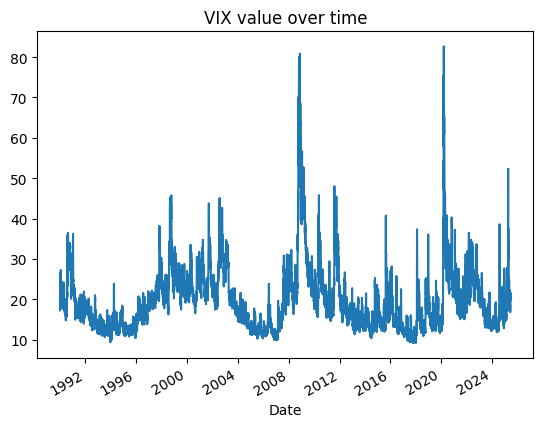

In [112]:


# Static graphs: hard to zoom in and get the exact dates of spikes
vix['Close'].plot.line(title = "VIX value over time")



In [113]:


# Dynamic visualisation of VIX prices
fig = px.line(vix,
              x=vix.index,
              y="Close",
              title='VIX over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()



### 3.2) Gold - other assets


In [114]:


# GOLD
# WEB: https://finance.yahoo.com/quote/GC%3DF

ticker_obj = yf.Ticker("GC=F")

# gold = yf.download(tickers = "GC=F",
#                      period = "max",
#                      interval = "1d")

gold = ticker_obj.history(
                     period = "max",
                     interval = "1d")



In [115]:
gold.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-24 00:00:00-04:00,3383.800049,3385.0,3347.0,3364.0,45029,0.0,0.0


In [116]:


gold_to_merge = get_growth_df(gold,'gold')
gold_to_merge.tail(2)



,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-23 00:00:00-04:00,1.002850,0.997372,1.016981,1.024601,1.159725,1.666683
2025-06-24 00:00:00-04:00,0.995944,0.992389,0.995001,1.008575,1.156411,1.660087


In [117]:


# Dynamic visualisation of GOLD prices
fig = px.line(gold,
              x=gold.index,
              y="Close",
              title='GOLD over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()



### 3.3) WTI Crude and Brent Oil


In [118]:
# WTI Crude Oil
# WEB: https://uk.finance.yahoo.com/quote/CL=F/

ticker_obj = yf.Ticker("CL=F")

# crude_oil = yf.download(tickers = "CL=F",
#                      period = "max",
#                      interval = "1d")

crude_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

In [119]:
crude_oil.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-23 00:00:00-04:00,78.000000,78.400002,66.599998,68.510002,678377,0.0,0.0
2025-06-24 00:00:00-04:00,67.739998,67.830002,64.379997,66.800003,105201,0.0,0.0


In [120]:


crude_oil_to_merge = get_growth_df(crude_oil,'wti_oil')
crude_oil_to_merge.tail(2)



,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
Date,,,,,,
2025-06-23 00:00:00-04:00,0.91432,0.915420,1.005282,1.143549,0.934397,0.968066
2025-06-24 00:00:00-04:00,0.97504,0.889007,0.981775,1.094723,0.935968,0.924696


In [121]:


# Dynamic visualisation
fig = px.line(crude_oil,
              x=crude_oil.index,
              y="Close",
              title='WTI Crude Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()



In [122]:


# Brent Oil
# WEB: https://uk.finance.yahoo.com/quote/BZ=F/

ticker_obj = yf.Ticker("BZ=F")

# brent_oil = yf.download(tickers = "BZ=F",
#                      period = "max",
#                      interval = "1d")

brent_oil = ticker_obj.history(
                     period = "max",
                     interval = "1d")

brent_oil.tail(2)



,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-23 00:00:00-04:00,80.010002,81.400002,69.540001,71.480003,98821,0.0,0.0
2025-06-24 00:00:00-04:00,70.599998,70.730003,67.339996,69.779999,9744,0.0,0.0


In [123]:


brent_oil_to_merge = get_growth_df(brent_oil,'brent_oil')
brent_oil_to_merge.tail(2)



,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
Date,,,,,,
2025-06-23 00:00:00-04:00,0.928191,0.934990,1.024509,1.137492,0.928312,0.939044
2025-06-24 00:00:00-04:00,0.976217,0.909778,1.006055,1.091848,0.928172,0.899343


In [124]:


# Dynamic visualisation
fig = px.line(brent_oil,
              x=brent_oil.index,
              y="Close",
              title='Brent Oil over time')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()




### 3.4) Bitcoin prices: BTC_USD


In [125]:
# https://finance.yahoo.com/quote/BTC-USD/

ticker_obj = yf.Ticker("BTC-USD")

# btc_usd =  yf.download(tickers = "BTC-USD",
#                      period = "max",
#                      interval = "1d")


btc_usd =  ticker_obj.history(
                     period = "max",
                     interval = "1d")

btc_usd.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-06-22 00:00:00+00:00,102212.031250,103351.632812,98286.203125,100987.140625,65536997201,0.0,0.0
2025-06-24 00:00:00+00:00,105416.820312,105533.234375,104826.750000,104976.007812,65556721664,0.0,0.0


In [126]:


btc_usd_to_merge = get_growth_df(btc_usd,'btc_usd')
btc_usd_to_merge.tail(2)



,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
Date,,,,,,
2025-06-22 00:00:00+00:00,0.987578,0.964683,0.956752,0.941273,1.154153,1.571721
2025-06-24 00:00:00+00:00,1.039499,1.016130,0.982951,0.973883,1.200114,1.661518


In [127]:
# Dynamic visualisation
fig = px.line(btc_usd,
              x=btc_usd.index,
              y="Close",
              title='Bitcoin price daily')
fig.update_layout(title_x=0.5)  # This will center the title horizontally

fig.show()


### 3.5 [Code snippet 4] Eurostat: "The home of high-quality statistics and data on Europe"

In [128]:


!pip install eurostat

# https://pypi.org/project/eurostat/
# https://ec.europa.eu/eurostat/web/main/data/database



In [129]:
import eurostat

In [130]:
# LONG WAIT TIME ~15 min, unless you filter data

# https://ec.europa.eu/eurostat/cache/metadata/en/irt_euryld_esms.htm
  # Euro yield curves (irt_euryld)
  # Reference Metadata in Euro SDMX Metadata Structure (ESMS)
  # Compiling agency: Eurostat, the statistical office of the European Uni

# the service is slow, you need to specify addtional params : https://pypi.org/project/eurostat/0.2.3/

filter_pars = {'startPeriod':'2025-05-01', 'endPeriod':'2025-06-01'}

code = 'irt_euryld_d'
eurostat_euro_yield_df = eurostat.get_data_df(code, flags=True, filter_pars=filter_pars,  verbose=True)

Download progress: 100.0%



In [131]:
eurostat_euro_yield_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2148 entries, 0 to 2147
Data columns (total 47 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   freq              2148 non-null   object 
 1   yld_curv          2148 non-null   object 
 2   maturity          2148 non-null   object 
 3   bonds             2148 non-null   object 
 4   geo\TIME_PERIOD   2148 non-null   object 
 5   2025-05-02_value  2148 non-null   float64
 6   2025-05-02_flag   2148 non-null   object 
 7   2025-05-05_value  2148 non-null   float64
 8   2025-05-05_flag   2148 non-null   object 
 9   2025-05-06_value  2148 non-null   float64
 10  2025-05-06_flag   2148 non-null   object 
 11  2025-05-07_value  2148 non-null   float64
 12  2025-05-07_flag   2148 non-null   object 
 13  2025-05-08_value  2148 non-null   float64
 14  2025-05-08_flag   2148 non-null   object 
 15  2025-05-09_value  2148 non-null   float64
 16  2025-05-09_flag   2148 non-null   object 


In [132]:
eurostat_euro_yield_df.head()

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,


In [133]:
eurostat_euro_yield_df['bonds'].value_counts()

,count
bonds,
CGB_EA,1074
CGB_EA_AAA,1074


In [134]:
eurostat_euro_yield_df['maturity'].value_counts()

,count
maturity,
Y9_M9,6
M10,6
M11,6
M3,6
M4,6
...,...
Y10,6
Y1,6
M9,6


In [135]:
eurostat_euro_yield_df['yld_curv'].value_counts()

,count
yld_curv,
INS_FWD,716
PAR,716
SPOT_RT,716


In [136]:
eurostat_euro_yield_df

,freq,yld_curv,maturity,bonds,geo\TIME_PERIOD,2025-05-02_value,2025-05-02_flag,2025-05-05_value,2025-05-05_flag,2025-05-06_value,...,2025-05-26_value,2025-05-26_flag,2025-05-27_value,2025-05-27_flag,2025-05-28_value,2025-05-28_flag,2025-05-29_value,2025-05-29_flag,2025-05-30_value,2025-05-30_flag
0,D,INS_FWD,M10,CGB_EA,EA,1.73842,,1.75209,,1.73532,...,1.71428,,1.71732,,1.73586,,1.70104,,1.73912,
1,D,INS_FWD,M10,CGB_EA_AAA,EA,1.69567,,1.68046,,1.70880,...,1.71962,,1.71396,,1.73539,,1.71651,,1.72649,
2,D,INS_FWD,M11,CGB_EA,EA,1.73363,,1.74807,,1.73333,...,1.71798,,1.72237,,1.73990,,1.70527,,1.74145,
3,D,INS_FWD,M11,CGB_EA_AAA,EA,1.68855,,1.67297,,1.70111,...,1.71803,,1.71302,,1.73309,,1.71424,,1.72509,
4,D,INS_FWD,M3,CGB_EA,EA,1.97791,,1.96619,,1.96325,...,1.94160,,1.93798,,1.94852,,1.93120,,1.93735,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2143,D,SPOT_RT,Y9_M7,CGB_EA_AAA,EA,2.56000,,2.58380,,2.61680,...,2.63569,,2.60094,,2.61034,,2.57690,,2.57548,
2144,D,SPOT_RT,Y9_M8,CGB_EA,EA,3.09194,,3.11837,,3.15733,...,3.13756,,3.09442,,3.10789,,3.06678,,3.07015,
2145,D,SPOT_RT,Y9_M8,CGB_EA_AAA,EA,2.56737,,2.59130,,2.62451,...,2.64314,,2.60802,,2.61738,,2.58400,,2.58254,
2146,D,SPOT_RT,Y9_M9,CGB_EA,EA,3.10140,,3.12818,,3.16710,...,3.14705,,3.10358,,3.11705,,3.07587,,3.07933,


In [137]:
# Visual graph: https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
FILTER = (eurostat_euro_yield_df.yld_curv=='SPOT_RT')& (eurostat_euro_yield_df.bonds=='CGB_EA_AAA')
filtered_eurostat_euro_yield_df = eurostat_euro_yield_df[FILTER]

In [138]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-05_value']].head(20)

,maturity,2025-05-05_value
1433,M10,1.79463
1435,M11,1.78389
1437,M3,1.91227
1439,M4,1.89037
1441,M5,1.87031
1443,M6,1.85200
1445,M7,1.83535
1447,M8,1.82029
1449,M9,1.80674
1451,Y1,1.77444


In [139]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity')[['maturity','2025-05-29_value']].head(20)

,maturity,2025-05-29_value
1433,M10,1.78884
1435,M11,1.78214
1437,M3,1.86951
1439,M4,1.85393
1441,M5,1.83981
1443,M6,1.82708
1445,M7,1.81569
1447,M8,1.80555
1449,M9,1.79662
1451,Y1,1.77647


In [140]:
import re

def extract_numbers(input_string):
    y_match = re.search(r'Y(\d+)', input_string)
    m_match = re.search(r'M(\d+)', input_string)

    y_number = int(y_match.group(1)) if y_match else 0
    m_number = int(m_match.group(1)) if m_match else 0


    return y_number*12 + m_number

# Examples
examples = ["Y10_M2", "M3", "Y1"]
for example in examples:
    res = extract_numbers(example)
    print(f"{example} ==> {res}")

Y10_M2 ==> 122
M3 ==> 3
Y1 ==> 12


In [141]:
# define new field: "maturity in months"
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_months'] = filtered_eurostat_euro_yield_df.maturity.apply(lambda x:extract_numbers(x))


/tmp/ipython-input-141-3842898120.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [142]:
filtered_eurostat_euro_yield_df.sort_values(by='maturity_in_months')[['maturity','maturity_in_months','2025-05-29_value']].head(20)

,maturity,maturity_in_months,2025-05-29_value
1437,M3,3,1.86951
1439,M4,4,1.85393
1441,M5,5,1.83981
1443,M6,6,1.82708
1445,M7,7,1.81569
1447,M8,8,1.80555
1449,M9,9,1.79662
1433,M10,10,1.78884
1435,M11,11,1.78214
1451,Y1,12,1.77647


In [143]:
filtered_eurostat_euro_yield_df.loc[:,'maturity_in_years'] = filtered_eurostat_euro_yield_df.maturity_in_months/12.0

/tmp/ipython-input-143-2163179308.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: title={'center': 'AAA rated bonds spot yield curve'}, xlabel='maturity_in_years'>

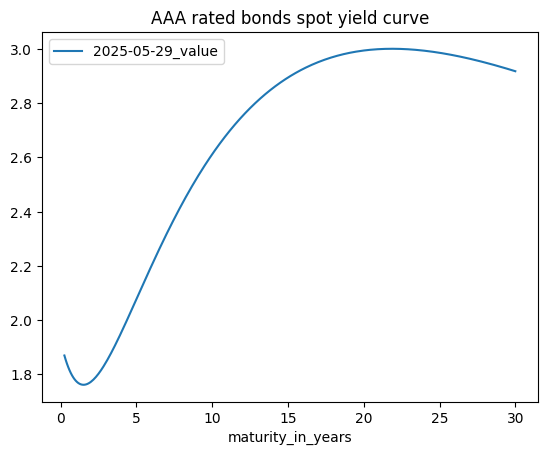

In [144]:
# exactly the same as on the Web:  https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html
filtered_eurostat_euro_yield_df \
  .sort_values(by='maturity_in_months')[['maturity_in_years','2025-05-29_value']] \
  .plot.line(x='maturity_in_years',
            y='2025-05-29_value',
            title='AAA rated bonds spot yield curve')


*italicized text*## 4) [Code Snippet 5] Fundamental indicators


    Read about "Ratio Analysis" to learn about more ratios: https://www.investopedia.com/terms/r/ratioanalysis.asp
    https://algotrading101.com/learn/yahoo-finance-api-guide/


In [145]:


# let's select some set of stocks: e.g. top US companies on 'Employees':
# https://companiesmarketcap.com/usa/largest-american-companies-by-number-of-employees/

US_TOP_EMPLOYEES_STOCKS = ['WMT','AMZN','UPS','HD','CNXC','TGT','KR','UNH','BRK-B','SBUX']

# WMT
ticker = US_TOP_EMPLOYEES_STOCKS[0]

# WMT ticker
one_company = yf.Ticker(ticker)



In [146]:


# Fundamental info appears close earning dates, you need to download it and use quickly (before/after trading day),
#  unless you're a fundamental long-term investor looking for a several months-quarters-years strategy (period between buy and sell)
# This dfthis is the easiest thing to join with the main dataset and get "some" technical indicators present
# WMT ticker
eps_earnings = one_company.earnings_dates
eps_earnings['Ticker'] = ticker
eps_earnings



,EPS Estimate,Reported EPS,Surprise(%),Ticker
Earnings Date,,,,
2026-05-13 09:30:00-04:00,NaN,NaN,NaN,WMT
2026-02-19 09:30:00-05:00,NaN,NaN,NaN,WMT
2025-11-20 09:30:00-05:00,NaN,NaN,NaN,WMT
2025-08-21 09:30:00-04:00,NaN,NaN,NaN,WMT
2025-05-15 07:01:00-04:00,0.58,0.61,5.93,WMT
2025-02-20 06:59:00-05:00,0.64,0.66,2.57,WMT
2024-11-19 07:00:00-05:00,0.53,0.58,8.82,WMT
2024-08-15 07:02:00-04:00,0.65,0.67,3.78,WMT
2024-05-16 07:01:00-04:00,0.52,0.60,14.60,WMT


In [147]:
one_company.calendar

{'Dividend Date': datetime.date(2026, 1, 5),
 'Ex-Dividend Date': datetime.date(2025, 8, 15),
 'Earnings Date': [datetime.date(2025, 8, 21)],
 'Earnings High': None,
 'Earnings Low': None,
 'Earnings Average': None,
 'Revenue High': 176653000000,
 'Revenue Low': 172272000000,
 'Revenue Average': 174085276030}

In [148]:
one_company.financials

,2025-01-31,2024-01-31,2023-01-31,2022-01-31,2021-01-31
Tax Effect Of Unusual Items,0.0,0.0,0.0,-612140000.0,NaN
Tax Rate For Calcs,0.234,0.255,0.336,0.254,NaN
Normalized EBITDA,42010000000.0,36384000000.0,30089000000.0,33758000000.0,NaN
Total Unusual Items,NaN,0.0,0.0,-2410000000.0,0.0
Total Unusual Items Excluding Goodwill,NaN,0.0,0.0,-2410000000.0,0.0
Net Income From Continuing Operation Net Minority Interest,19436000000.0,15511000000.0,11680000000.0,13673000000.0,NaN
Reconciled Depreciation,12973000000.0,11853000000.0,10945000000.0,10658000000.0,NaN
Reconciled Cost Of Revenue,511753000000.0,490142000000.0,463721000000.0,429000000000.0,NaN
EBITDA,42010000000.0,36384000000.0,30089000000.0,31348000000.0,NaN
EBIT,29037000000.0,24531000000.0,19144000000.0,20690000000.0,NaN


In [149]:


EPS = one_company.financials.loc['Basic EPS']
EPS



,Basic EPS
2025-01-31,2.42
2024-01-31,1.92
2023-01-31,1.43
2022-01-31,1.633333
2021-01-31,NaN


In [150]:
# or should we use NORMALIZED_EBITDA?
EBITDA = one_company.financials.loc['EBITDA']
EBITDA_margin = one_company.financials.loc['EBITDA'] /  one_company.financials.loc['Total Revenue']


In [151]:
EBITDA_margin

,0
2025-01-31,0.06169
2024-01-31,0.056137
2023-01-31,0.049222
2022-01-31,0.054732
2021-01-31,NaN


In [152]:
NET_INCOME = one_company.financials.loc['Net Income']
NET_INCOME_margin = one_company.financials.loc['Net Income'] /  one_company.financials.loc['Total Revenue']


In [153]:
NET_INCOME

,Net Income
2025-01-31,19436000000.0
2024-01-31,15511000000.0
2023-01-31,11680000000.0
2022-01-31,13673000000.0
2021-01-31,NaN


In [154]:


# Compare with Public information - you can fully replicate the numbers (yearly and/or quarterly):
# https://www.wsj.com/market-data/quotes/WMT/financials/annual/income-statement
NET_INCOME_margin



,0
2025-01-31,0.028541
2024-01-31,0.023932
2023-01-31,0.019107
2022-01-31,0.023872
2021-01-31,NaN


In [155]:


# Combine the series into a DataFrame
df_fin_ratios = pd.DataFrame({
    'NET_INCOME_margin': 100.0 * NET_INCOME_margin, #for visualisation -- Margin in %
    'EBITDA_margin': 100.0 *EBITDA_margin, #for visualisation -- Margin in %
    'EPS': EPS
})



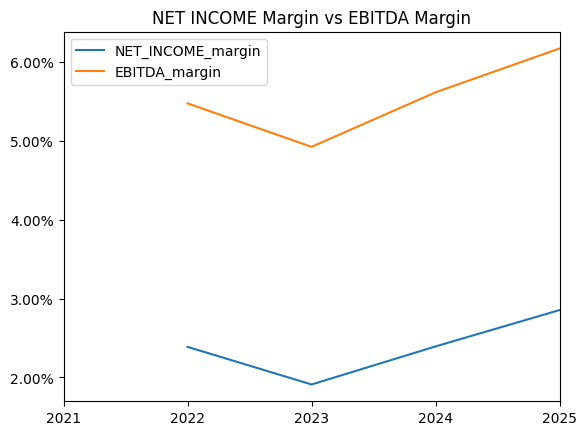

In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Assuming df_fin_ratios is your DataFrame containing the financial ratios
# Make sure you have already created this DataFrame

# Plotting the specified columns
ax = df_fin_ratios[['NET_INCOME_margin','EBITDA_margin']].plot.line()

# Setting the y-axis formatter to display values as percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# Adding title
plt.title('NET INCOME Margin vs EBITDA Margin')

# Displaying the plot
plt.show()

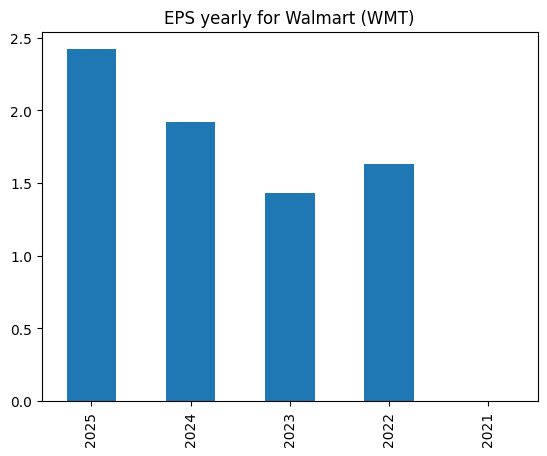

In [157]:


EPS_year = df_fin_ratios['EPS'].index.year

df_fin_ratios['EPS'].plot.bar(title = 'EPS yearly for Walmart (WMT)')

plt.xticks(range(len(EPS_year)), EPS_year)
# Displaying the plot
plt.show()



**bold text**## 5) [Code snippet 7] Daily OHCLV data for a set of stocks

In [158]:
# https://companiesmarketcap.com/usa/largest-companies-in-the-usa-by-market-cap/
US_STOCKS = ['MSFT', 'AAPL', 'GOOG', 'NVDA', 'AMZN', 'META', 'BRK-B', 'LLY', 'AVGO','V', 'JPM']

# You're required to add EU_STOCKS and INDIA_STOCS
# https://companiesmarketcap.com/european-union/largest-companies-in-the-eu-by-market-cap/
EU_STOCKS = ['NVO','MC.PA', 'ASML', 'RMS.PA', 'OR.PA', 'SAP', 'ACN', 'TTE', 'SIE.DE','IDEXY','CDI.PA']

# https://companiesmarketcap.com/india/largest-companies-in-india-by-market-cap/
INDIA_STOCKS = ['RELIANCE.NS','TCS.NS','HDB','BHARTIARTL.NS','IBN','SBIN.NS','LICI.NS','INFY','ITC.NS','HINDUNILVR.NS','LT.NS']


In [159]:
ALL_TICKERS = US_STOCKS  + EU_STOCKS + INDIA_STOCKS
ALL_TICKERS

['MSFT',
 'AAPL',
 'GOOG',
 'NVDA',
 'AMZN',
 'META',
 'BRK-B',
 'LLY',
 'AVGO',
 'V',
 'JPM',
 'NVO',
 'MC.PA',
 'ASML',
 'RMS.PA',
 'OR.PA',
 'SAP',
 'ACN',
 'TTE',
 'SIE.DE',
 'IDEXY',
 'CDI.PA',
 'RELIANCE.NS',
 'TCS.NS',
 'HDB',
 'BHARTIARTL.NS',
 'IBN',
 'SBIN.NS',
 'LICI.NS',
 'INFY',
 'ITC.NS',
 'HINDUNILVR.NS',
 'LT.NS']

In [160]:
import time

stocks_df = pd.DataFrame({'A' : []})

for i,ticker in enumerate(ALL_TICKERS):
  print(i,ticker)

  # Work with stock prices
  ticker_obj = yf.Ticker(ticker)

  # historyPrices = yf.download(tickers = ticker,
  #                    period = "max",
  #                    interval = "1d")
  historyPrices = ticker_obj.history(
                     period = "max",
                     interval = "1d")

  # generate features for historical prices, and what we want to predict
  historyPrices['Ticker'] = ticker
  historyPrices['Year']= historyPrices.index.year
  historyPrices['Month'] = historyPrices.index.month
  historyPrices['Weekday'] = historyPrices.index.weekday
  historyPrices['Date'] = historyPrices.index.date

  # historical returns
  for i in [1,3,7,30,90,365]:
    historyPrices['growth_'+str(i)+'d'] = historyPrices['Close'] / historyPrices['Close'].shift(i)
  historyPrices['growth_future_30d'] = historyPrices['Close'].shift(-30) / historyPrices['Close']

  # Technical indicators
  # SimpleMovingAverage 10 days and 20 days
  historyPrices['SMA10']= historyPrices['Close'].rolling(10).mean()
  historyPrices['SMA20']= historyPrices['Close'].rolling(20).mean()
  historyPrices['growing_moving_average'] = np.where(historyPrices['SMA10'] > historyPrices['SMA20'], 1, 0)
  historyPrices['high_minus_low_relative'] = (historyPrices.High - historyPrices.Low) / historyPrices['Close']

  # 30d rolling volatility : https://ycharts.com/glossary/terms/rolling_vol_30
  historyPrices['volatility'] =   historyPrices['Close'].rolling(30).std() * np.sqrt(252)

  # what we want to predict
  historyPrices['is_positive_growth_30d_future'] = np.where(historyPrices['growth_future_30d'] > 1, 1, 0)

  # sleep 1 sec between downloads - not to overload the API server
  time.sleep(1)


  if stocks_df.empty:
    stocks_df = historyPrices
  else:
    stocks_df = pd.concat([stocks_df, historyPrices], ignore_index=True)

0 MSFT
1 AAPL
2 GOOG
3 NVDA
4 AMZN
5 META
6 BRK-B
7 LLY
8 AVGO
9 V
10 JPM
11 NVO
12 MC.PA
13 ASML
14 RMS.PA
15 OR.PA
16 SAP
17 ACN
18 TTE
19 SIE.DE
20 IDEXY
21 CDI.PA
22 RELIANCE.NS
23 TCS.NS
24 HDB
25 BHARTIARTL.NS
26 IBN
27 SBIN.NS
28 LICI.NS
29 INFY
30 ITC.NS
31 HINDUNILVR.NS
32 LT.NS


In [161]:


def get_ticker_type(ticker:str, us_stocks_list, eu_stocks_list, india_stocks_list):
  if ticker in us_stocks_list:
    return 'US'
  elif ticker in eu_stocks_list:
    return 'EU'
  elif ticker in india_stocks_list:
    return 'INDIA'
  else:
    return 'ERROR'




In [162]:
stocks_df['ticker_type'] = stocks_df.Ticker.apply(lambda x:get_ticker_type(x, US_STOCKS, EU_STOCKS, INDIA_STOCKS))

In [163]:


# count of observations between US-EU-INDIA stocks
stocks_df.ticker_type.value_counts()



,count
ticker_type,
US,83819
EU,80193
INDIA,66436


In [164]:


# unique tickers
stocks_df.Ticker.nunique()



33

In [165]:


# count of observations by stock
stocks_df.Ticker.value_counts()



,count
Ticker,
LLY,13376
JPM,11410
AAPL,11222
NVO,11127
MSFT,9896
CDI.PA,8616
TTE,8474
ASML,7619
SAP,7490


In [166]:
stocks_df.groupby(['Ticker','ticker_type']).Date.agg(['min','max'])

,,min,max
Ticker,ticker_type,,
AAPL,US,1980-12-12,2025-06-23
ACN,EU,2001-07-19,2025-06-23
AMZN,US,1997-05-15,2025-06-23
ASML,EU,1995-03-15,2025-06-23
AVGO,US,2009-08-06,2025-06-23
BHARTIARTL.NS,INDIA,2002-07-01,2025-06-24
BRK-B,US,1996-05-09,2025-06-23
CDI.PA,EU,1992-01-27,2025-06-23
GOOG,US,2004-08-19,2025-06-23


In [167]:
#  average growth 365days
stocks_df[stocks_df.Year>=2020].groupby(by=['Year','ticker_type']).growth_365d.mean()

Year  ticker_type
2020  EU             1.245388
      INDIA          1.098703
      US             1.484070
2021  EU             1.582166
      INDIA          1.545082
      US             1.797571
2022  EU             1.191167
      INDIA          1.379889
      US             1.182379
2023  EU             1.246531
      INDIA          1.199860
      US             1.203253
2024  EU             1.406437
      INDIA          1.352715
      US             2.159361
2025  EU             1.164794
      INDIA          1.214415
      US             1.668534
Name: growth_365d, dtype: float64

In [168]:
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [169]:


# filtering only on stats after 2000
stocks_df[stocks_df.Date>='2000-01-01'].info()



<class 'pandas.core.frame.DataFrame'>
Index: 191981 entries, 3490 to 230447
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           191981 non-null  float64       
 1   High                           191981 non-null  float64       
 2   Low                            191981 non-null  float64       
 3   Close                          191981 non-null  float64       
 4   Volume                         191981 non-null  int64         
 5   Dividends                      191981 non-null  float64       
 6   Stock Splits                   191981 non-null  float64       
 7   Ticker                         191981 non-null  object        
 8   Year                           191981 non-null  int32         
 9   Month                          191981 non-null  int32         
 10  Weekday                        191981 non-null  int32         
 11  Da

In [170]:
stocks_df[stocks_df.Date=='2025-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_90d,growth_365d,growth_future_30d,SMA10,SMA20,growing_moving_average,high_minus_low_relative,volatility,is_positive_growth_30d_future,ticker_type
203268,795.000000,806.000000,792.099976,797.750000,726877,0.0,0.0,LICI.NS,2025,4,...,0.904530,1.249596,1.071827,786.810004,767.930005,1,0.017424,337.725353,1,INDIA
209880,18.190001,18.209999,17.950001,18.200001,13574900,0.0,0.0,INFY,2025,4,...,0.842593,1.105543,1.014286,18.432000,18.730500,0,0.014286,17.068021,1,INDIA
217280,402.386004,406.902788,398.262008,399.292999,15206240,0.0,0.0,ITC.NS,2025,4,...,0.903574,0.964762,1.070577,400.068704,398.897778,1,0.021640,69.909597,1,INDIA
224683,2235.491201,2260.874172,2196.897064,2210.603027,2495962,0.0,0.0,HINDUNILVR.NS,2025,4,...,0.937490,0.912701,1.066634,2213.789429,2192.072791,1,0.028941,683.812269,1,INDIA
230391,3447.844234,3469.244743,3398.306242,3405.043457,1935147,0.0,0.0,LT.NS,2025,4,...,0.986594,1.119635,1.047544,3377.198193,3277.881909,1,0.020833,1726.860104,1,INDIA


## 6) [Code Snippet 8] Technical Indicators with TA-lib

- PythonInvest article on Tech. Indicators
- Code for generating 100+ tech. indicators/patterns : https://github.com/realmistic/PythonInvest-basic-fin-analysis/blob/master/colab_notebooks/Part14_Exploring_Tech_Indicators_For_Stocks_and_Crypto.ipynb

Indicator groups: https://github.com/TA-Lib/ta-lib-python/blob/master/README.md


    Overlap Studies (17)
    Momentum Indicators (30+)
    Volume Indicators (3)
    Cycle Indicators (5)
    Price Transform (4)
    Volatility Indicators (3)
    Pattern Recognition (60)


In [171]:
# [2025 way - seems to be working] https://medium.com/@Tobi_Lux/collaboration-of-colab-yfinance-and-ta-lib-recent-issues-6cd8eebb56b0
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
!pip install conda-package-handling
!wget https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
!cph x ta-lib-0.5.1-py311h9ecbd09_0.conda

# 🛠 Option 1: Remove the existing directory first (clean, but destructive)
!rm -rf /usr/local/lib/python3.11/dist-packages/talib

!mv ./ta-lib-0.5.1-py311h9ecbd09_0/lib/python3.11/site-packages/talib /usr/local/lib/python3.11/dist-packages/
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3975    0  3975    0     0   9020      0 --:--:-- --:--:-- --:--:--  9013
100  517k  100  517k    0     0   264k      0  0:00:01  0:00:01 --:--:-- 1120k
--2025-06-24 04:29:26--  https://anaconda.org/conda-forge/ta-lib/0.5.1/download/linux-64/ta-lib-0.5.1-py311h9ecbd09_0.conda
Resolving anaconda.org (anaconda.org)... 104.19.145.37, 104.19.144.37, 2606:4700::6813:9025, ...
Connecting to anaconda.org (anaconda.org)|104.19.145.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5f738b4b78d4370a69f82984/673b62920c609ff6945bb24d?response-content-disposition=attachment%3B%20filename%3D%22ta-lib-0.5.1-py311h9ecbd09_0.conda%22%3B%20filename%2A%3DUTF-8%27%27ta-lib-0.5.1-py311h9ecbd09_0.conda&response-content-type=application%2Foctet-stream&X-Amz-Algorithm=

### 6.1) Momentum indicators

https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/momentum_indicators.md

In [172]:
def talib_get_momentum_indicators_for_one_ticker(df: pd.DataFrame) -> pd.DataFrame:
  # ADX - Average Directional Movement Index
  talib_momentum_adx = talib.ADX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # ADXR - Average Directional Movement Index Rating
  talib_momentum_adxr = talib.ADXR(df.High.values, df.Low.values, df.Close.values, timeperiod=14 )
  # APO - Absolute Price Oscillator
  talib_momentum_apo = talib.APO(df.Close.values, fastperiod=12, slowperiod=26, matype=0 )
  # AROON - Aroon
  talib_momentum_aroon = talib.AROON(df.High.values, df.Low.values, timeperiod=14 )
  # talib_momentum_aroon[0].size
  # talib_momentum_aroon[1].size
  # AROONOSC - Aroon Oscillator
  talib_momentum_aroonosc = talib.AROONOSC(df.High.values, df.Low.values, timeperiod=14)
  # BOP - Balance of Power
  # https://school.stockcharts.com/doku.php?id=technical_indicators:balance_of_power
     #calculate open prices as shifted closed prices from the prev day
     # open = df.Last.shift(1)
  talib_momentum_bop = talib.BOP(df.Open.values, df.High.values, df.Low.values, df.Close.values)
  # CCI - Commodity Channel Index
  talib_momentum_cci = talib.CCI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # CMO - Chande Momentum Oscillator
  talib_momentum_cmo = talib.CMO(df.Close.values, timeperiod=14)
  # DX - Directional Movement Index
  talib_momentum_dx = talib.DX(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # MACD - Moving Average Convergence/Divergence
  talib_momentum_macd, talib_momentum_macdsignal, talib_momentum_macdhist = talib.MACD(df.Close.values, fastperiod=12, \
                                                                                       slowperiod=26, signalperiod=9)
  # MACDEXT - MACD with controllable MA type
  talib_momentum_macd_ext, talib_momentum_macdsignal_ext, talib_momentum_macdhist_ext = talib.MACDEXT(df.Close.values, \
                                                                                                    fastperiod=12, \
                                                                                                    fastmatype=0, \
                                                                                                    slowperiod=26, \
                                                                                                    slowmatype=0, \
                                                                                                    signalperiod=9, \
                                                                                                  signalmatype=0)
  # MACDFIX - Moving Average Convergence/Divergence Fix 12/26
  talib_momentum_macd_fix, talib_momentum_macdsignal_fix, talib_momentum_macdhist_fix = talib.MACDFIX(df.Close.values, \
                                                                                                      signalperiod=9)
  # MFI - Money Flow Index
  talib_momentum_mfi = talib.MFI(df.High.values, df.Low.values, df.Close.values, df.Volume.values, timeperiod=14)
  # MINUS_DI - Minus Directional Indicator
  talib_momentum_minus_di = talib.MINUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # MOM - Momentum
  talib_momentum_mom = talib.MOM(df.Close.values, timeperiod=10)
  # PLUS_DI - Plus Directional Indicator
  talib_momentum_plus_di = talib.PLUS_DI(df.High.values, df.Low.values, df.Close.values, timeperiod=14)
  # PLUS_DM - Plus Directional Movement
  talib_momentum_plus_dm = talib.PLUS_DM(df.High.values, df.Low.values, timeperiod=14)
  # PPO - Percentage Price Oscillator
  talib_momentum_ppo = talib.PPO(df.Close.values, fastperiod=12, slowperiod=26, matype=0)
  # ROC - Rate of change : ((price/prevPrice)-1)*100
  talib_momentum_roc = talib.ROC(df.Close.values, timeperiod=10)
  # ROCP - Rate of change Percentage: (price-prevPrice)/prevPrice
  talib_momentum_rocp = talib.ROCP(df.Close.values, timeperiod=10)
  # ROCR - Rate of change ratio: (price/prevPrice)
  talib_momentum_rocr = talib.ROCR(df.Close.values, timeperiod=10)
  # ROCR100 - Rate of change ratio 100 scale: (price/prevPrice)*100
  talib_momentum_rocr100 = talib.ROCR100(df.Close.values, timeperiod=10)
  # RSI - Relative Strength Index
  talib_momentum_rsi = talib.RSI(df.Close.values, timeperiod=14)
  # STOCH - Stochastic
  talib_momentum_slowk, talib_momentum_slowd = talib.STOCH(df.High.values, df.Low.values, df.Close.values, \
                                                           fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
  # STOCHF - Stochastic Fast
  talib_momentum_fastk, talib_momentum_fastd = talib.STOCHF(df.High.values, df.Low.values, df.Close.values, \
                                                            fastk_period=5, fastd_period=3, fastd_matype=0)
  # STOCHRSI - Stochastic Relative Strength Index
  talib_momentum_fastk_rsi, talib_momentum_fastd_rsi = talib.STOCHRSI(df.Close.values, timeperiod=14, \
                                                                      fastk_period=5, fastd_period=3, fastd_matype=0)
  # TRIX - 1-day Rate-Of-Change (ROC) of a Triple Smooth EMA
  talib_momentum_trix = talib.TRIX(df.Close.values, timeperiod=30)
  # ULTOSC - Ultimate Oscillator
  talib_momentum_ultosc = talib.ULTOSC(df.High.values, df.Low.values, df.Close.values, timeperiod1=7, timeperiod2=14, timeperiod3=28)
  # WILLR - Williams' %R
  talib_momentum_willr = talib.WILLR(df.High.values, df.Low.values, df.Close.values, timeperiod=14)

  momentum_df =   pd.DataFrame(
    {
      # assume here multi-index
      # 'datetime': df.index.get_level_values(0),
      # 'ticker': df.index.get_level_values(1) ,

      # old way with separate columns
      'Date': df.Date.values,
      'Ticker': df.Ticker,

      'adx': talib_momentum_adx,
      'adxr': talib_momentum_adxr,
      'apo': talib_momentum_apo,
      'aroon_1': talib_momentum_aroon[0] ,
      'aroon_2': talib_momentum_aroon[1],
      'aroonosc': talib_momentum_aroonosc,
      'bop': talib_momentum_bop,
      'cci': talib_momentum_cci,
      'cmo': talib_momentum_cmo,
      'dx': talib_momentum_dx,
      'macd': talib_momentum_macd,
      'macdsignal': talib_momentum_macdsignal,
      'macdhist': talib_momentum_macdhist,
      'macd_ext': talib_momentum_macd_ext,
      'macdsignal_ext': talib_momentum_macdsignal_ext,
      'macdhist_ext': talib_momentum_macdhist_ext,
      'macd_fix': talib_momentum_macd_fix,
      'macdsignal_fix': talib_momentum_macdsignal_fix,
      'macdhist_fix': talib_momentum_macdhist_fix,
      'mfi': talib_momentum_mfi,
      'minus_di': talib_momentum_minus_di,
      'mom': talib_momentum_mom,
      'plus_di': talib_momentum_plus_di,
      'dm': talib_momentum_plus_dm,
      'ppo': talib_momentum_ppo,
      'roc': talib_momentum_roc,
      'rocp': talib_momentum_rocp,
      'rocr': talib_momentum_rocr,
      'rocr100': talib_momentum_rocr100,
      'rsi': talib_momentum_rsi,
      'slowk': talib_momentum_slowk,
      'slowd': talib_momentum_slowd,
      'fastk': talib_momentum_fastk,
      'fastd': talib_momentum_fastd,
      'fastk_rsi': talib_momentum_fastk_rsi,
      'fastd_rsi': talib_momentum_fastd_rsi,
      'trix': talib_momentum_trix,
      'ultosc': talib_momentum_ultosc,
      'willr': talib_momentum_willr,
     }
  )
  return momentum_df

### 6.2 Volume, Volatility, Cycle, Price indicators

https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md

In [173]:
def talib_get_volume_volatility_cycle_price_indicators(df: pd.DataFrame) -> pd.DataFrame:
        # TA-Lib Volume indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volume_indicators.md
        # AD - Chaikin A/D Line
        talib_ad = talib.AD(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values)
        # ADOSC - Chaikin A/D Oscillator
        talib_adosc = talib.ADOSC(
            df.High.values, df.Low.values, df.Close.values, df.Volume.values, fastperiod=3, slowperiod=10)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Volatility indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/volatility_indicators.md
        # ATR - Average True Range
        talib_atr = talib.ATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # NATR - Normalized Average True Range
        talib_natr = talib.NATR(
            df.High.values, df.Low.values, df.Close.values, timeperiod=14)
        # OBV - On Balance Volume
        talib_obv = talib.OBV(
            df.Close.values, df.Volume.values)

        # TA-Lib Cycle Indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/cycle_indicators.md
        # HT_DCPERIOD - Hilbert Transform - Dominant Cycle Period
        talib_ht_dcperiod = talib.HT_DCPERIOD(df.Close.values)
        # HT_DCPHASE - Hilbert Transform - Dominant Cycle Phase
        talib_ht_dcphase = talib.HT_DCPHASE(df.Close.values)
        # HT_PHASOR - Hilbert Transform - Phasor Components
        talib_ht_phasor_inphase, talib_ht_phasor_quadrature = talib.HT_PHASOR(
            df.Close.values)
        # HT_SINE - Hilbert Transform - SineWave
        talib_ht_sine_sine, talib_ht_sine_leadsine = talib.HT_SINE(
            df.Close.values)
        # HT_TRENDMODE - Hilbert Transform - Trend vs Cycle Mode
        talib_ht_trendmode = talib.HT_TRENDMODE(df.Close.values)

        # TA-Lib Price Transform Functions
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/price_transform.md
        # AVGPRICE - Average Price
        talib_avgprice = talib.AVGPRICE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # MEDPRICE - Median Price
        talib_medprice = talib.MEDPRICE(df.High.values, df.Low.values)
        # TYPPRICE - Typical Price
        talib_typprice = talib.TYPPRICE(
            df.High.values, df.Low.values, df.Close.values)
        # WCLPRICE - Weighted Close Price
        talib_wclprice = talib.WCLPRICE(
            df.High.values, df.Low.values, df.Close.values)

        volume_volatility_cycle_price_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Volume indicators
             'ad': talib_ad,
             'adosc': talib_adosc,
             'obv': talib_obv,
             # TA-Lib Volatility indicators
             'atr': talib_atr,
             'natr': talib_natr,
             'obv': talib_obv,
             # TA-Lib Cycle Indicators
             'ht_dcperiod': talib_ht_dcperiod,
             'ht_dcphase': talib_ht_dcphase,
             'ht_phasor_inphase': talib_ht_phasor_inphase,
             'ht_phasor_quadrature': talib_ht_phasor_quadrature,
             'ht_sine_sine': talib_ht_sine_sine,
             'ht_sine_leadsine': talib_ht_sine_leadsine,
             'ht_trendmod': talib_ht_trendmode,
             # TA-Lib Price Transform Functions
             'avgprice': talib_avgprice,
             'medprice': talib_medprice,
             'typprice': talib_typprice,
             'wclprice': talib_wclprice,
             }
        )

        # Need a proper date type
        volume_volatility_cycle_price_df['Date'] = pd.to_datetime(
            volume_volatility_cycle_price_df['Date'])

        return volume_volatility_cycle_price_df

### 6.3) Pattern indicators

https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md

In [174]:
def talib_get_pattern_recognition_indicators(df: pd.DataFrame) -> pd.DataFrame:
# TA-Lib Pattern Recognition indicators
        # https://github.com/TA-Lib/ta-lib-python/blob/master/docs/func_groups/pattern_recognition.md
        # Nice article about candles (pattern recognition) https://medium.com/analytics-vidhya/recognizing-over-50-candlestick-patterns-with-python-4f02a1822cb5

        # CDL2CROWS - Two Crows
        talib_cdl2crows = talib.CDL2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3BLACKCROWS - Three Black Crows
        talib_cdl3blackrows = talib.CDL3BLACKCROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3INSIDE - Three Inside Up/Down
        talib_cdl3inside = talib.CDL3INSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3LINESTRIKE - Three-Line Strike
        talib_cdl3linestrike = talib.CDL3LINESTRIKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3OUTSIDE - Three Outside Up/Down
        talib_cdl3outside = talib.CDL3OUTSIDE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3STARSINSOUTH - Three Stars In The South
        talib_cdl3starsinsouth = talib.CDL3STARSINSOUTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDL3WHITESOLDIERS - Three Advancing White Soldiers
        talib_cdl3whitesoldiers = talib.CDL3WHITESOLDIERS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLABANDONEDBABY - Abandoned Baby
        talib_cdlabandonedbaby = talib.CDLABANDONEDBABY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLADVANCEBLOCK - Advance Block
        talib_cdladvancedblock = talib.CDLADVANCEBLOCK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBELTHOLD - Belt-hold
        talib_cdlbelthold = talib.CDLBELTHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLBREAKAWAY - Breakaway
        talib_cdlbreakaway = talib.CDLBREAKAWAY(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCLOSINGMARUBOZU - Closing Marubozu
        talib_cdlclosingmarubozu = talib.CDLCLOSINGMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCONCEALBABYSWALL - Concealing Baby Swallow
        talib_cdlconcealbabyswall = talib.CDLCONCEALBABYSWALL(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLCOUNTERATTACK - Counterattack
        talib_cdlcounterattack = talib.CDLCOUNTERATTACK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDARKCLOUDCOVER - Dark Cloud Cover
        talib_cdldarkcloudcover = talib.CDLDARKCLOUDCOVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLDOJI - Doji
        talib_cdldoji = talib.CDLDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDOJISTAR - Doji Star
        talib_cdldojistar = talib.CDLDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLDRAGONFLYDOJI - Dragonfly Doji
        talib_cdldragonflydoji = talib.CDLDRAGONFLYDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLENGULFING - Engulfing Pattern
        talib_cdlengulfing = talib.CDLENGULFING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLEVENINGDOJISTAR - Evening Doji Star
        talib_cdleveningdojistar = talib.CDLEVENINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLEVENINGSTAR - Evening Star
        talib_cdleveningstar = talib.CDLEVENINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLGAPSIDESIDEWHITE - Up/Down-gap side-by-side white lines
        talib_cdlgapsidesidewhite = talib.CDLGAPSIDESIDEWHITE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLGRAVESTONEDOJI - Gravestone Doji
        talib_cdlgravestonedoji = talib.CDLGRAVESTONEDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHAMMER - Hammer
        talib_cdlhammer = talib.CDLHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHANGINGMAN - Hanging Man
        talib_cdlhangingman = talib.CDLHANGINGMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMI - Harami Pattern
        talib_cdlharami = talib.CDLHARAMI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHARAMICROSS - Harami Cross Pattern
        talib_cdlharamicross = talib.CDLHARAMICROSS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIGHWAVE - High-Wave Candle
        talib_cdlhighwave = talib.CDLHIGHWAVE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKE - Hikkake Pattern
        talib_cdlhikkake = talib.CDLHIKKAKE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLHIKKAKEMOD - Modified Hikkake Pattern
        talib_cdlhikkakemod = talib.CDLHIKKAKEMOD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLHOMINGPIGEON - Homing Pigeon
        talib_cdlhomingpigeon = talib.CDLHOMINGPIGEON(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLIDENTICAL3CROWS - Identical Three Crows
        talib_cdlidentical3crows = talib.CDLIDENTICAL3CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINNECK - In-Neck Pattern
        talib_cdlinneck = talib.CDLINNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLINVERTEDHAMMER - Inverted Hammer
        talib_cdlinvertedhammer = talib.CDLINVERTEDHAMMER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKING - Kicking
        talib_cdlkicking = talib.CDLKICKING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLKICKINGBYLENGTH - Kicking - bull/bear determined by the longer marubozu
        talib_cdlkickingbylength = talib.CDLKICKINGBYLENGTH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLADDERBOTTOM - Ladder Bottom
        talib_cdlladderbottom = talib.CDLLADDERBOTTOM(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLEGGEDDOJI - Long Legged Doji
        talib_cdllongleggeddoji = talib.CDLLONGLEGGEDDOJI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLLONGLINE - Long Line Candle
        talib_cdllongline = talib.CDLLONGLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMARUBOZU - Marubozu
        talib_cdlmarubozu = talib.CDLMARUBOZU(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLMATCHINGLOW - Matching Low
        talib_cdlmatchinglow = talib.CDLMATCHINGLOW(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLMATHOLD - Mat Hold
        talib_cdlmathold = talib.CDLMATHOLD(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGDOJISTAR - Morning Doji Star
        talib_cdlmorningdojistar = talib.CDLMORNINGDOJISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLMORNINGSTAR - Morning Star
        talib_cdlmorningstar = talib.CDLMORNINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values, penetration=0)
        # CDLONNECK - On-Neck Pattern
        talib_cdlonneck = talib.CDLONNECK(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLPIERCING - Piercing Pattern
        talib_cdlpiercing = talib.CDLPIERCING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRICKSHAWMAN - Rickshaw Man
        talib_cdlrickshawman = talib.CDLRICKSHAWMAN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLRISEFALL3METHODS - Rising/Falling Three Methods
        talib_cdlrisefall3methods = talib.CDLRISEFALL3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSEPARATINGLINES - Separating Lines
        talib_cdlseparatinglines = talib.CDLSEPARATINGLINES(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHOOTINGSTAR - Shooting Star
        talib_cdlshootingstar = talib.CDLSHOOTINGSTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSHORTLINE - Short Line Candle
        talib_cdlshortline = talib.CDLSHORTLINE(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSPINNINGTOP - Spinning Top
        talib_cdlspinningtop = talib.CDLSPINNINGTOP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        # CDLSTALLEDPATTERN - Stalled Pattern
        talib_cdlstalledpattern = talib.CDLSTALLEDPATTERN(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLSTICKSANDWICH - Stick Sandwich
        talib_cdlsticksandwich = talib.CDLSTICKSANDWICH(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTAKURI - Takuri (Dragonfly Doji with very long lower shadow)
        talib_cdltakuru = talib.CDLTAKURI(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTASUKIGAP - Tasuki Gap
        talib_cdltasukigap = talib.CDLTASUKIGAP(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTHRUSTING - Thrusting Pattern
        talib_cdlthrusting = talib.CDLTHRUSTING(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLTRISTAR - Tristar Pattern
        talib_cdltristar = talib.CDLTRISTAR(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUNIQUE3RIVER - Unique 3 River
        talib_cdlunique3river = talib.CDLUNIQUE3RIVER(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLUPSIDEGAP2CROWS - Upside Gap Two Crows
        talib_cdlupsidegap2crows = talib.CDLUPSIDEGAP2CROWS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)
        # CDLXSIDEGAP3METHODS - Upside/Downside Gap Three Methods
        talib_cdlxsidegap3methods = talib.CDLXSIDEGAP3METHODS(
            df.Open.values, df.High.values, df.Low.values, df.Close.values)

        pattern_indicators_df = pd.DataFrame(
            {'Date': df.Date.values,
             'Ticker': df.Ticker,
             # TA-Lib Pattern Recognition indicators
             'cdl2crows': talib_cdl2crows,
             'cdl3blackrows': talib_cdl3blackrows,
             'cdl3inside': talib_cdl3inside,
             'cdl3linestrike': talib_cdl3linestrike,
             'cdl3outside': talib_cdl3outside,
             'cdl3starsinsouth': talib_cdl3starsinsouth,
             'cdl3whitesoldiers': talib_cdl3whitesoldiers,
             'cdlabandonedbaby': talib_cdlabandonedbaby,
             'cdladvancedblock': talib_cdladvancedblock,
             'cdlbelthold': talib_cdlbelthold,
             'cdlbreakaway': talib_cdlbreakaway,
             'cdlclosingmarubozu': talib_cdlclosingmarubozu,
             'cdlconcealbabyswall': talib_cdlconcealbabyswall,
             'cdlcounterattack': talib_cdlcounterattack,
             'cdldarkcloudcover': talib_cdldarkcloudcover,
             'cdldoji': talib_cdldoji,
             'cdldojistar': talib_cdldojistar,
             'cdldragonflydoji': talib_cdldragonflydoji,
             'cdlengulfing': talib_cdlengulfing,
             'cdleveningdojistar': talib_cdleveningdojistar,
             'cdleveningstar': talib_cdleveningstar,
             'cdlgapsidesidewhite': talib_cdlgapsidesidewhite,
             'cdlgravestonedoji': talib_cdlgravestonedoji,
             'cdlhammer': talib_cdlhammer,
             'cdlhangingman': talib_cdlhangingman,
             'cdlharami': talib_cdlharami,
             'cdlharamicross': talib_cdlharamicross,
             'cdlhighwave': talib_cdlhighwave,
             'cdlhikkake': talib_cdlhikkake,
             'cdlhikkakemod': talib_cdlhikkakemod,
             'cdlhomingpigeon': talib_cdlhomingpigeon,
             'cdlidentical3crows': talib_cdlidentical3crows,
             'cdlinneck': talib_cdlinneck,
             'cdlinvertedhammer': talib_cdlinvertedhammer,
             'cdlkicking': talib_cdlkicking,
             'cdlkickingbylength': talib_cdlkickingbylength,
             'cdlladderbottom': talib_cdlladderbottom,
             'cdllongleggeddoji': talib_cdllongleggeddoji,
             'cdllongline': talib_cdllongline,
             'cdlmarubozu': talib_cdlmarubozu,
             'cdlmatchinglow': talib_cdlmatchinglow,
             'cdlmathold': talib_cdlmathold,
             'cdlmorningdojistar': talib_cdlmorningdojistar,
             'cdlmorningstar': talib_cdlmorningstar,
             'cdlonneck': talib_cdlonneck,
             'cdlpiercing': talib_cdlpiercing,
             'cdlrickshawman': talib_cdlrickshawman,
             'cdlrisefall3methods': talib_cdlrisefall3methods,
             'cdlseparatinglines': talib_cdlseparatinglines,
             'cdlshootingstar': talib_cdlshootingstar,
             'cdlshortline': talib_cdlshortline,
             'cdlspinningtop': talib_cdlspinningtop,
             'cdlstalledpattern': talib_cdlstalledpattern,
             'cdlsticksandwich': talib_cdlsticksandwich,
             'cdltakuru': talib_cdltakuru,
             'cdltasukigap': talib_cdltasukigap,
             'cdlthrusting': talib_cdlthrusting,
             'cdltristar': talib_cdltristar,
             'cdlunique3river': talib_cdlunique3river,
             'cdlupsidegap2crows': talib_cdlupsidegap2crows,
             'cdlxsidegap3methods': talib_cdlxsidegap3methods
             }
        )

        # Need a proper date type
        pattern_indicators_df['Date'] = pd.to_datetime(
            pattern_indicators_df['Date'])

        return pattern_indicators_df

### 6.4) Calculate Tech Indicators and Merge to the original dataframe

In [175]:


# Volume needs to be float, not int
stocks_df['Volume'] = stocks_df['Volume']*1.0



In [176]:
# to resolve an error "Exception: input array type is not double"
# https://stackoverflow.com/questions/51712269/how-to-run-ta-lib-on-multiple-columns-of-a-pandas-dataframe
for f in ['Open','High','Low','Close', 'Volume', 'Close']:
  stocks_df.loc[:,f] = stocks_df.loc[:,f].astype('float64')

In [177]:
stocks_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230448 entries, 0 to 230447
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   Open                           230448 non-null  float64       
 1   High                           230448 non-null  float64       
 2   Low                            230448 non-null  float64       
 3   Close                          230448 non-null  float64       
 4   Volume                         230448 non-null  float64       
 5   Dividends                      230448 non-null  float64       
 6   Stock Splits                   230448 non-null  float64       
 7   Ticker                         230448 non-null  object        
 8   Year                           230448 non-null  int32         
 9   Month                          230448 non-null  int32         
 10  Weekday                        230448 non-null  int32         
 11  

In [178]:
import pandas as pd
# supress warnings
pd.options.mode.chained_assignment = None  # default='warn'

# adding Momentum / Pattern/ Volume features to all tickers - one by one
merged_df_with_tech_ind = pd.DataFrame({'A' : []})

current_ticker_data = None
i=0
for ticker in ALL_TICKERS:
  i+=1
  print(f'{i}/{len(ALL_TICKERS)} Current ticker is {ticker}')
  current_ticker_data = stocks_df[stocks_df.Ticker.isin([ticker])]
  # need to have same 'utc' time on both sides
  # https://stackoverflow.com/questions/73964894/you-are-trying-to-merge-on-datetime64ns-utc-and-datetime64ns-columns-if-yo
  current_ticker_data['Date']= pd.to_datetime(current_ticker_data['Date'], utc=True)

  # 3 calls to get additional features
  df_current_ticker_momentum_indicators = talib_get_momentum_indicators_for_one_ticker(current_ticker_data)
  df_current_ticker_momentum_indicators["Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)
  # df_current_ticker_momentum_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_momentum_indicators['Date'], utc=True)

  df_current_ticker_volume_indicators = talib_get_volume_volatility_cycle_price_indicators(current_ticker_data)
  df_current_ticker_volume_indicators["Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)
  # df_current_ticker_volume_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_volume_indicators['Date'], utc=True)

  df_current_ticker_pattern_indicators = talib_get_pattern_recognition_indicators(current_ticker_data)
  df_current_ticker_pattern_indicators["Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)
  # df_current_ticker_pattern_indicators.loc[:,"Date"]= pd.to_datetime(df_current_ticker_pattern_indicators['Date'], utc=True)

  # merge to one df
  m1 = pd.merge(current_ticker_data, df_current_ticker_momentum_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m2 = pd.merge(m1, df_current_ticker_volume_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")
  m3 = pd.merge(m2, df_current_ticker_pattern_indicators.reset_index(), how = 'left', on = ["Date","Ticker"], validate = "one_to_one")

  if merged_df_with_tech_ind.empty:
    merged_df_with_tech_ind = m3
  else:
    merged_df_with_tech_ind = pd.concat([merged_df_with_tech_ind,m3], ignore_index = False)

1/33 Current ticker is MSFT
2/33 Current ticker is AAPL
3/33 Current ticker is GOOG
4/33 Current ticker is NVDA
5/33 Current ticker is AMZN
6/33 Current ticker is META
7/33 Current ticker is BRK-B
8/33 Current ticker is LLY
9/33 Current ticker is AVGO
10/33 Current ticker is V
11/33 Current ticker is JPM
12/33 Current ticker is NVO
13/33 Current ticker is MC.PA
14/33 Current ticker is ASML
15/33 Current ticker is RMS.PA
16/33 Current ticker is OR.PA
17/33 Current ticker is SAP
18/33 Current ticker is ACN
19/33 Current ticker is TTE
20/33 Current ticker is SIE.DE
21/33 Current ticker is IDEXY
22/33 Current ticker is CDI.PA
23/33 Current ticker is RELIANCE.NS
24/33 Current ticker is TCS.NS
25/33 Current ticker is HDB
26/33 Current ticker is BHARTIARTL.NS
27/33 Current ticker is IBN
28/33 Current ticker is SBIN.NS
29/33 Current ticker is LICI.NS
30/33 Current ticker is INFY
31/33 Current ticker is ITC.NS
32/33 Current ticker is HINDUNILVR.NS
33/33 Current ticker is LT.NS


In [179]:
merged_df_with_tech_ind[merged_df_with_tech_ind.Date=='2024-04-01'].tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
463,919.998455,979.127016,919.003862,965.351868,4863536.0,0.0,0.0,LICI.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
6304,17.336117,17.365189,16.958192,17.035715,14601600.0,0.0,0.0,INFY,2024,4,...,0,0,0,0,0,0,0,0,0,0
7095,407.560804,409.697862,404.378955,405.281281,9382308.0,0.0,0.0,ITC.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
7098,2215.878840,2240.282792,2208.069575,2231.399658,1427873.0,0.0,0.0,HINDUNILVR.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0
5403,3716.697971,3786.493268,3716.697971,3772.878174,1905190.0,0.0,0.0,LT.NS,2024,4,...,0,0,0,0,0,0,0,0,0,0


In [180]:
merged_df_with_tech_ind.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230448 entries, 0 to 5707
Columns: 145 entries, Open to cdlxsidegap3methods
dtypes: datetime64[ns, UTC](1), float64(72), int32(65), int64(5), object(2)
memory usage: 199.6+ MB


## 7) [Code snippet 9] Merge All Together

In [181]:
merged_df_with_tech_ind.head(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdlspinningtop,cdlstalledpattern,cdlsticksandwich,cdltakuru,cdltasukigap,cdlthrusting,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods
0,0.054277,0.062259,0.054277,0.059598,1.031789e+09,0.0,0.0,MSFT,1986,3,...,0,0,0,0,0,0,0,0,0,0


In [182]:
merged_df_with_tech_ind.shape

(230448, 145)

In [183]:
# make sure it is dateTime with no timezone
merged_df_with_tech_ind['Date'] = pd.to_datetime(merged_df_with_tech_ind['Date']).dt.tz_localize(None)


In [184]:


# merge with dax_daily_to_merge
dax_daily_to_merge.tail(1)



,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
Date,,,,,,
2025-06-23 00:00:00+02:00,0.996508,0.997907,0.978864,0.987375,1.050613,1.392973


In [185]:
dax_daily_to_merge.index = dax_daily_to_merge.index.tz_localize(None)

In [186]:


m2 = pd.merge(merged_df_with_tech_ind,
              dax_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
)



In [187]:
m2.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,cdltristar,cdlunique3river,cdlupsidegap2crows,cdlxsidegap3methods,growth_dax_1d,growth_dax_3d,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,6,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:


# check the same number of records, but columns increased
m2.shape



(230448, 151)

In [189]:


# merge with dax_daily_to_merge
snp500_to_merge.tail(1)



,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
Date,,,,,,
2025-06-23 00:00:00-04:00,1.009607,1.007095,1.000486,1.063777,0.99286,1.282704


In [190]:
snp500_to_merge.index = snp500_to_merge.index.tz_localize(None)

In [191]:


m3 = pd.merge(m2,
              snp500_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )



In [192]:
m3.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_dax_7d,growth_dax_30d,growth_dax_90d,growth_dax_365d,growth_snp500_1d,growth_snp500_3d,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [193]:


m3.shape



(230448, 157)

In [194]:


dji_daily_to_merge.index = dji_daily_to_merge.index.tz_localize(None)



In [195]:
m4 = pd.merge(m3,
              dji_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [196]:
m4.shape

(230448, 163)

In [197]:
m4.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_snp500_7d,growth_snp500_30d,growth_snp500_90d,growth_snp500_365d,growth_dji_1d,growth_dji_3d,growth_dji_7d,growth_dji_30d,growth_dji_90d,growth_dji_365d
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
epi_etf_daily_to_merge.index = epi_etf_daily_to_merge.index.tz_localize(None)

In [199]:
m5 = pd.merge(m4,
              epi_etf_daily_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )

In [200]:
m5.shape

(230448, 169)

In [201]:
# define quarter as the first date of qtr
m5['Quarter'] = m5['Date'].dt.to_period('Q').dt.to_timestamp()
m5['Quarter']

,Quarter
0,1986-01-01
1,1986-01-01
2,1986-01-01
3,1986-01-01
4,1986-01-01
...,...
5703,2025-04-01
5704,2025-04-01
5705,2025-04-01
5706,2025-04-01


In [202]:
gdppot_to_merge.tail(1)

,gdppot_us_yoy,gdppot_us_qoq
DATE,,
2025-04-01,0.023029,0.005716


In [203]:
m6 = pd.merge(m5,
              gdppot_to_merge,
              how='left',
              left_on='Quarter',
              right_index=True,
              validate = "many_to_one"
              )

In [204]:


m6.tail(2)



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_dji_365d,growth_epi_1d,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,6,...,1.136541,1.006757,1.005223,0.976326,1.060133,1.080974,1.117292,2025-04-01,0.023029,0.005716
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716


In [205]:


m6.shape



(230448, 172)

In [206]:
m6['Month'] = m6['Date'].dt.to_period('M').dt.to_timestamp()
m6['Month']

,Month
0,1986-03-01
1,1986-03-01
2,1986-03-01
3,1986-03-01
4,1986-03-01
...,...
5703,2025-06-01
5704,2025-06-01
5705,2025-06-01
5706,2025-06-01


In [207]:


cpilfesl_to_merge.tail(1)



,cpi_core_yoy,cpi_core_mom
DATE,,
2025-05-01,0.027671,0.001299


In [208]:


m7 = pd.merge(m6,
              cpilfesl_to_merge,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )



In [212]:


# PROBLEM! Last month is not defined
m7.tail(1)



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299


In [210]:


fields_to_fill = ['cpi_core_yoy',	'cpi_core_mom']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m7[field] = m7[field].ffill()




In [213]:
m7.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_3d,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299


In [214]:


fedfunds.tail(1)



,FEDFUNDS
DATE,
2025-05-01,4.33


In [215]:
m8 = pd.merge(m7,
              fedfunds,
              how='left',
              left_on='Month',
              right_index=True,
              validate = "many_to_one"
              )

In [216]:


m8.tail(1)



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,NaN


In [217]:
fields_to_fill = ['FEDFUNDS']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m8[field] = m8[field].ffill()

In [218]:


m8.tail(1)



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_7d,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33


In [222]:


dgs1.tail(1)



,DGS1
DATE,
2025-06-20,4.07


In [223]:


m9 = pd.merge(m8,
              dgs1,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )



In [224]:
# fix last day later
m9.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_30d,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.060133,1.080974,1.117292,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN


In [225]:


m10 = pd.merge(m9,
              dgs5,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )



In [226]:


# fix last day later
m10.tail(2)



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_90d,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.080974,1.117292,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN


In [227]:


m11 = pd.merge(m10,
              dgs10,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )



In [228]:


m11.tail(2)



,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_epi_365d,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.117292,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN


In [229]:


vix_to_merge



,Close
Date,
1990-01-02 00:00:00-06:00,17.240000
1990-01-03 00:00:00-06:00,18.190001
1990-01-04 00:00:00-06:00,19.219999
1990-01-05 00:00:00-06:00,20.110001
1990-01-08 00:00:00-06:00,20.260000
...,...
2025-06-16 00:00:00-05:00,19.110001
2025-06-17 00:00:00-05:00,21.600000
2025-06-18 00:00:00-05:00,20.139999


In [230]:
vix_to_merge.index = vix_to_merge.index.tz_localize(None)

In [231]:


m12 = pd.merge(m11,
              vix_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )



In [232]:


m12.tail(2)



,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,Quarter,gdppot_us_yoy,gdppot_us_qoq,cpi_core_yoy,cpi_core_mom,FEDFUNDS,DGS1,DGS5,DGS10,Close_y
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN,19.83
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,2025-04-01,0.023029,0.005716,0.027671,0.001299,4.33,NaN,NaN,NaN,NaN


In [233]:
gold_to_merge.tail(2)

,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
Date,,,,,,
2025-06-23 00:00:00-04:00,1.002850,0.997372,1.016981,1.024601,1.159725,1.666683
2025-06-24 00:00:00-04:00,0.995944,0.992389,0.995001,1.008575,1.156411,1.660087


In [234]:
gold_to_merge.index = gold_to_merge.index.tz_localize(None)

In [235]:


m13 = pd.merge(m12,
              gold_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )



In [236]:
m13.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,DGS1,DGS5,DGS10,Close_y,growth_gold_1d,growth_gold_3d,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,19.83,1.002850,0.997372,1.016981,1.024601,1.159725,1.666683
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,NaN,NaN,NaN,NaN,0.995944,0.992389,0.995001,1.008575,1.156411,1.660087


In [237]:
crude_oil_to_merge.index = crude_oil_to_merge.index.tz_localize(None)

In [238]:


m14 = pd.merge(m13,
              crude_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )



In [239]:
m14.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_gold_7d,growth_gold_30d,growth_gold_90d,growth_gold_365d,growth_wti_oil_1d,growth_wti_oil_3d,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.016981,1.024601,1.159725,1.666683,0.91432,0.915420,1.005282,1.143549,0.934397,0.968066
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,0.995001,1.008575,1.156411,1.660087,0.97504,0.889007,0.981775,1.094723,0.935968,0.924696


In [240]:
brent_oil_to_merge.index = brent_oil_to_merge.index.tz_localize(None)

In [241]:


m15 = pd.merge(m14,
              brent_oil_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )



In [242]:
m15.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_wti_oil_7d,growth_wti_oil_30d,growth_wti_oil_90d,growth_wti_oil_365d,growth_brent_oil_1d,growth_brent_oil_3d,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.005282,1.143549,0.934397,0.968066,0.928191,0.934990,1.024509,1.137492,0.928312,0.939044
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,0.981775,1.094723,0.935968,0.924696,0.976217,0.909778,1.006055,1.091848,0.928172,0.899343


In [243]:
btc_usd_to_merge.index = btc_usd_to_merge.index.tz_localize(None)

In [244]:
m16 = pd.merge(m15,
              btc_usd_to_merge,
              how='left',
              left_on='Date',
              right_index=True,
              validate = "many_to_one"
              )


In [245]:
m16.tail(2)

,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.024509,1.137492,0.928312,0.939044,NaN,NaN,NaN,NaN,NaN,NaN
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.006055,1.091848,0.928172,0.899343,1.039499,1.01613,0.982951,0.973883,1.200114,1.661518


In [246]:
fields_to_fill = ['gdppot_us_yoy','gdppot_us_qoq','cpi_core_yoy','cpi_core_mom','FEDFUNDS','DGS1','DGS5','DGS10']
# Fill missing values in selected fields with the last defined value
for field in fields_to_fill:
    m16[field] = m16[field].ffill()

In [247]:


m16.tail(2)



,Open,High,Low,Close_x,Volume,Dividends,Stock Splits,Ticker,Year,Month,...,growth_brent_oil_7d,growth_brent_oil_30d,growth_brent_oil_90d,growth_brent_oil_365d,growth_btc_usd_1d,growth_btc_usd_3d,growth_btc_usd_7d,growth_btc_usd_30d,growth_btc_usd_90d,growth_btc_usd_365d
5706,3645.000000,3660.0,3574.600098,3583.699951,1867977.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.024509,1.137492,0.928312,0.939044,NaN,NaN,NaN,NaN,NaN,NaN
5707,3637.100098,3664.0,3615.699951,3653.600098,414414.0,0.0,0.0,LT.NS,2025,2025-06-01,...,1.006055,1.091848,0.928172,0.899343,1.039499,1.01613,0.982951,0.973883,1.200114,1.661518


In [248]:
m16.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230448 entries, 0 to 5707
Columns: 203 entries, Open to growth_btc_usd_365d
dtypes: datetime64[ns](3), float64(129), int32(64), int64(5), object(2)
memory usage: 302.4+ MB


In [249]:


date = m16.Date.max()
date_str = date.strftime('%Y_%m_%d')
print(date_str)



2025_06_24


In [250]:


m16.to_parquet(f'stocks_df_combined_{date_str}.parquet.brotli',
              compression='brotli')

